In [ ]:
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
import spacy
import numpy as np
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train = pd.read_csv("/content/train.csv")

TEKSTO APDOROJIMAS

In [ ]:
#ar yra tusciu reiksmiu
train.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

1. Nereikšmingų žodžių, skyrybos ženklų šalinimas ir didžiųjų raidžių pavertimas į mažąsias

In [ ]:
#mokymo aibei
zdz = set(stopwords.words('english'))
train['clean_abstract_processed'] = train['ABSTRACT'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(re.sub(r'[^a-zA-Z\s]', '', str(x)))
                                                                    if word.lower() not in zdz]))
# salinam skyrybos zenklus
train['clean_abstract'] = \
train['clean_abstract_processed'].map(lambda x: re.sub('[,\.!?]', '', x))
# Konvertuojam didziasias raides i mazasias
train['clean_abstract'] = \
train['clean_abstract'].map(lambda x: x.lower())


train.head()

ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   
2        0            1           0                     0   
3        0            1           0                     0   
4        0            0           1                     0   

   Quantitative Finance                           clean_abstract_processed  \
0                     0  Predictive models allow subjectspecific infere...   
1                     0  Rotation invariance translation invariance gre...   
2                     0  introduce develop notion spherical polyharmoni...   
3                     0  stochastic LandauLifshitzGilbert LLG equation ...   
4                     0  Fouriertransform infrared FTIR spectra samples...   

                                      clean_abstract  
0  predictive models allow subjectspecific infere...  
1  rotation invariance translation invariance gre...  
2  introduce develop notion spherical polyharmoni...  
3  stochastic landaulifshitzgilbert llg equation ...  
4  fouriertransform infrared ftir spectra samples...

2. Pagrindinės formos

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
#mokymo aibei
lemmatized = [' '.join([token.lemma_ for token in nlp(text)]) for text in train['clean_abstract']]

train['clean_abstract_lemmatized'] = lemmatized

train.head()

ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   
2        0            1           0                     0   
3        0            1           0                     0   
4        0            0           1                     0   

   Quantitative Finance                           clean_abstract_processed  \
0                     0  Predictive models allow subjectspecific infere...   
1                     0  Rotation invariance translation invariance gre...   
2                     0  introduce develop notion spherical polyharmoni...   
3                     0  stochastic LandauLifshitzGilbert LLG equation ...   
4                     0  Fouriertransform infrared FTIR spectra samples...   

                                      clean_abstract  \
0  predictive models allow subjectspecific infere...   
1  rotation invariance translation invariance gre...   
2  introduce develop notion spherical polyharmoni...   
3  stochastic landaulifshitzgilbert llg equation ...   
4  fouriertransform infrared ftir spectra samples...   

                           clean_abstract_lemmatized  
0  predictive model allow subjectspecific inferen...  
1  rotation invariance translation invariance gre...  
2  introduce develop notion spherical polyharmoni...  
3  stochastic landaulifshitzgilbert llg equation ...  
4  fouriertransform infrared ftir spectra sample ...

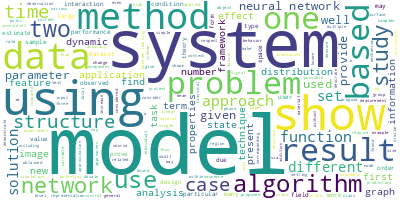

In [ ]:
# Vaizdavimas, kurie zodziai dazniausiai naudojami tekstuose
long_string = ','.join(list(train['clean_abstract'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=4, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

 # Latent Dirichlet Allocation (LDA)

Nuorodos:
* https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/
* https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

## be stopwords + lemmatized + tfidf

In [ ]:
vect = TfidfVectorizer(max_features=1000)
vect_text=vect.fit_transform(train['clean_abstract_lemmatized'])

In [ ]:
lda_tfidf=LatentDirichletAllocation(n_components=13,learning_method='online',random_state=42,max_iter=1)
lda_top=lda_tfidf.fit_transform(vect_text)

In [ ]:
vocab = vect.get_feature_names_out()
for i, comp in enumerate(lda_tfidf.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
     print(" ")

Topic 0: 
query transmission database answer search handle segmentation algorithm since curve  
Topic 1: 
protein contact controller depth force water joint reconstruction robot control  
Topic 2: 
question answer whether topological symmetry hamiltonian spectrum phase superconducte continuous  
Topic 3: 
tensor dark matter decomposition detection rank standard perturbation matrix scenario  
Topic 4: 
phase magnetic energy state field temperature model system transition quantum  
Topic 5: 
equation prove space function give solution operator result problem show  
Topic 6: 
algorithm model method problem distribution propose estimator datum use sample  
Topic 7: 
group let category ring algebra finite conjecture representation prove graph  
Topic 8: 
cell sensor plane laser simulation surface patient datum vehicle conventional  
Topic 9: 
network model use datum learn propose method system approach algorithm  
Topic 10: 
code channel capacity communication quantum body binary rate trans

In [ ]:
H = lda_tfidf.components_
words = np.array(vect.get_feature_names_out())

for i, topic in enumerate(H):
  sarasas=",".join([str(x) for x in words[topic.argsort()[::-1][:10]]])
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(sarasas)
  plt.imshow(wc)
  plt.title(f"Topic{i+1}")
  plt.axis("off")
  plt.show()

In [ ]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_Cv(model, df_columnm):
  topics = model.components_

  n_top_words = 10
  texts = [[word for word in doc.split()] for doc in df_columnm]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [ ]:
get_Cv(lda_tfidf, train['clean_abstract_lemmatized'])

0.35207723099109073

## be stopwords + lemmatized + CountVectorizer

In [ ]:
count_vec = CountVectorizer(max_features = 1000)
count_vec_text = count_vec.fit_transform(train['clean_abstract_lemmatized'])

In [ ]:
lda_count =LatentDirichletAllocation(n_components=13,learning_method='online',random_state=42,max_iter=1)
lda_top=lda_count.fit_transform(count_vec_text)

In [ ]:
vocab = count_vec.get_feature_names_out()
for i, comp in enumerate(lda_count.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
     print("")

Topic 0: 
equation solution code nonlinear scheme boundary flow motion use method 
Topic 1: 
phase energy state quantum temperature transition magnetic system show material 
Topic 2: 
theory function operator space type field show property representation order 
Topic 3: 
problem algorithm method function optimization gradient propose stochastic optimal control 
Topic 4: 
algorithm problem matrix method propose game power time number strategy 
Topic 5: 
group result space give bound case also paper define show 
Topic 6: 
model distribution sample datum method estimate use parameter estimator estimation 
Topic 7: 
graph set number show give point prove result class proof 
Topic 8: 
network structure system two model measure social population cell different 
Topic 9: 
use network datum learn model propose method approach task neural 
Topic 10: 
use system dynamic field time robot present control process study 
Topic 11: 
cluster star galaxy find time use pattern region formation observati

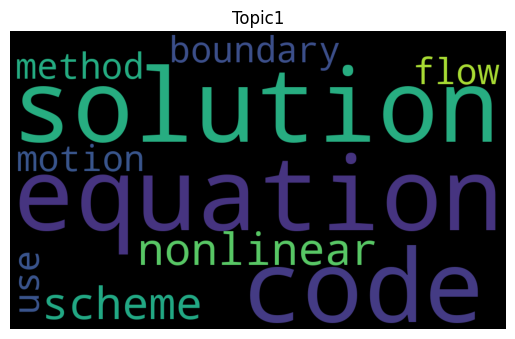

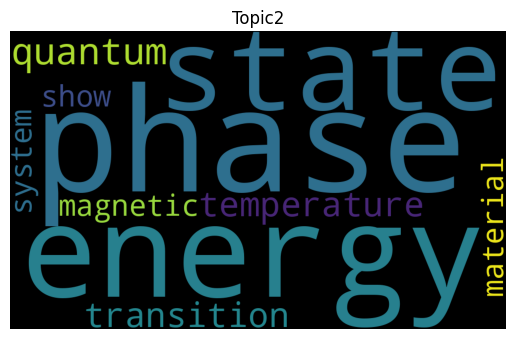

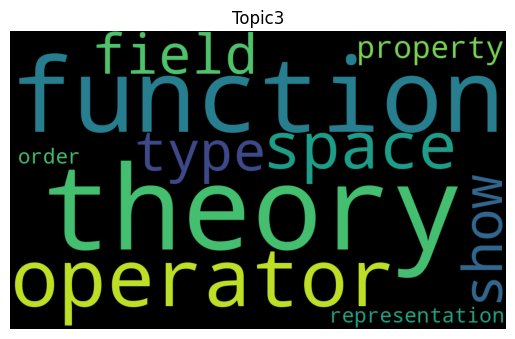

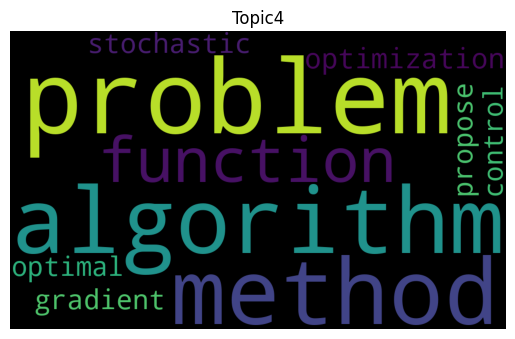

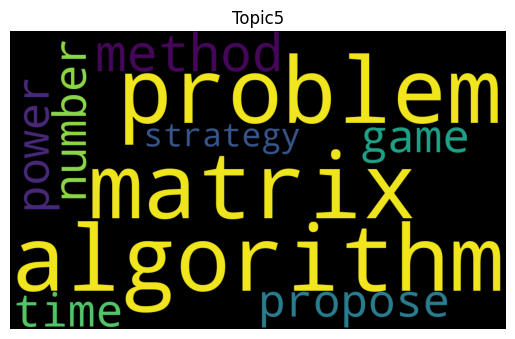

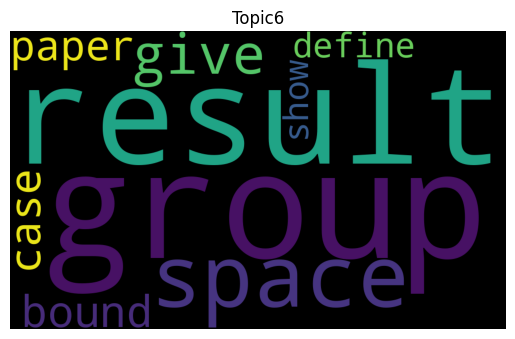

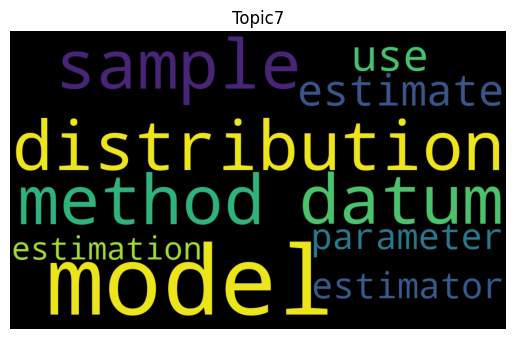

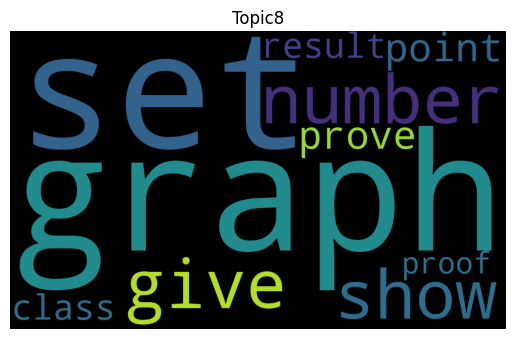

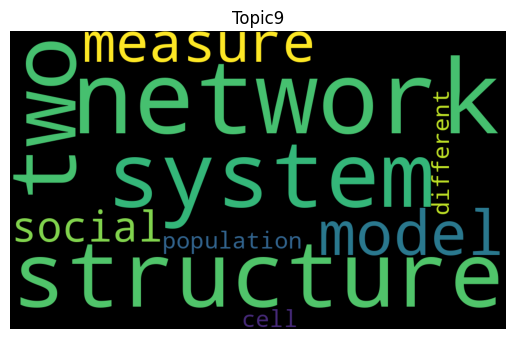

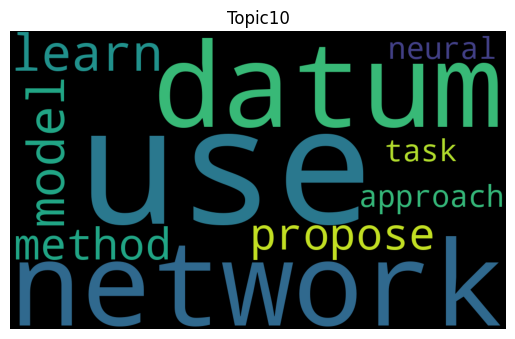

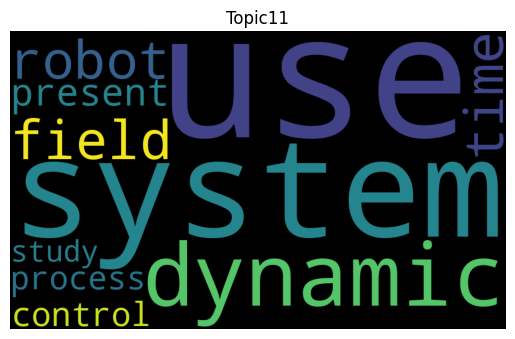

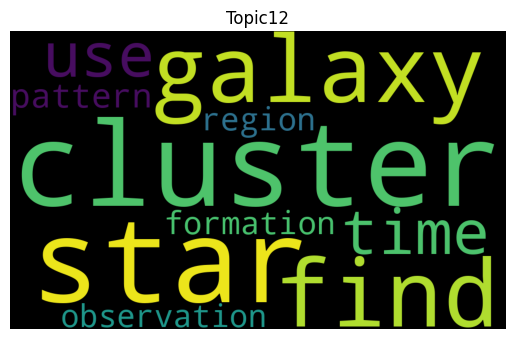

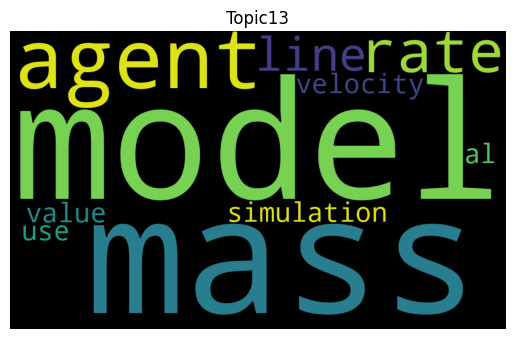

In [ ]:
H = lda_count.components_
words = np.array(count_vec.get_feature_names_out())

for i, topic in enumerate(H):
  sarasas=",".join([str(x) for x in words[topic.argsort()[::-1][:10]]])
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(sarasas)
  plt.imshow(wc)
  plt.title(f"Topic{i+1}")
  plt.axis("off")
  plt.show()

In [ ]:
get_Cv(lda_count, train['clean_abstract_lemmatized'])

0.3156323373668852

# Coherence score for different numbers of topics

In [ ]:
# Skaidom teksta i tokenus

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = train.clean_abstract_lemmatized.values.tolist()
data_words = list(sent_to_words(data))

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Skaiciuojam zodziu dazni
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Calculate coherence scores for different numbers of topics
def calculate_coherence_score(corpus, id2word, texts, max_topics):
    coherence_scores = []
    for num_topics in range(2, max_topics + 1):
        model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
    return coherence_scores

# Set the maximum number of topics to explore
max_topics_to_explore = 15

# Calculate coherence scores
coherence_scores = calculate_coherence_score(corpus, id2word, texts, max_topics_to_explore)

# Plot the coherence scores
plt.plot(range(2, max_topics_to_explore + 1), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score for Different Numbers of Topics")
plt.show()


# Latent Semantic Analysis (LSA)

Nuorodos:
* https://www.datacamp.com/tutorial/discovering-hidden-topics-python?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720824&utm_adgroupid=157156376311&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=676136073491&utm_targetid=dsa-2218886984100&utm_loc_interest_ms=&utm_loc_physical_ms=9062284&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p2_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na&gad_source=1&gclid=Cj0KCQiAr8eqBhD3ARIsAIe-buOgoxaaymygUiZrQ5x6RjCCiuVxyQoKex5-Z6kd4kM9tJd7rIXvVfEaAibZEALw_wcB
* https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/

Be nereikšmingų žodžių ir su pagrindinėmis formomis + TfidfVectorizer()

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#mokymo aibei
#ivertiname zodziu svarbuma
tfidf = TfidfVectorizer()
tfidf.fit(train['clean_abstract_lemmatized'])

X = tfidf.transform(train['clean_abstract_lemmatized'])

In [ ]:
num_topics = 13
lsa = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_result = lsa.fit_transform(X)

topics = pd.DataFrame(lsa_result, columns=[f'Topic {i+1}' for i in range(num_topics)])

In [ ]:
vocab = tfidf.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
     print(" ")

Topic 0: 
model network method use algorithm problem datum propose learn system  
Topic 1: 
network learn neural deep task training datum image learning model  
Topic 2: 
algorithm problem graph function matrix optimization solution prove bound set  
Topic 3: 
network graph group neural node deep prove space edge give  
Topic 4: 
system algorithm problem control solution optimization robot equation solve policy  
Topic 5: 
graph algorithm edge cluster node vertex time galaxy datum star  
Topic 6: 
network stochastic distribution estimator neural function parameter equation gradient optimization  
Topic 7: 
model system graph equation control dynamic solution user process agent  
Topic 8: 
graph learn model quantum phase state spin magnetic transition learning  
Topic 9: 
equation graph solution image method nonlinear wave flow differential boundary  
Topic 10: 
learn model galaxy star problem mass algorithm learning agent deep  
Topic 11: 
graph estimator control function distribution 

Topic #1: model, network, method, use, algorithm, problem, datum, propose, learn, system


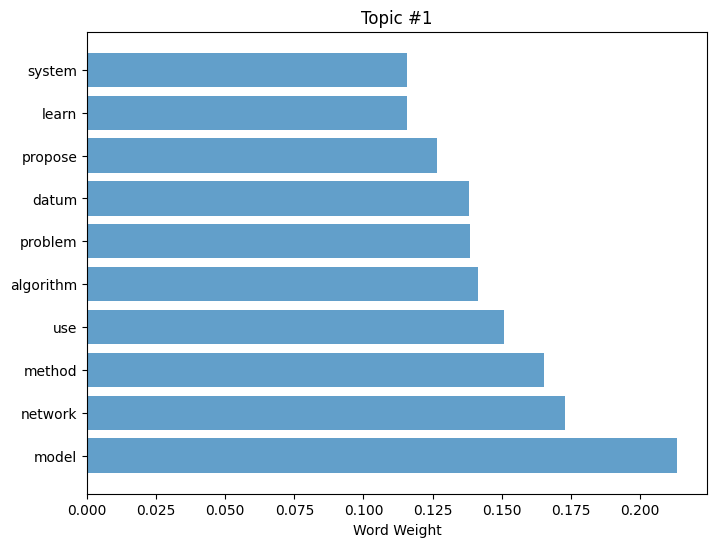

Topic #2: network, learn, neural, deep, task, training, datum, image, learning, model


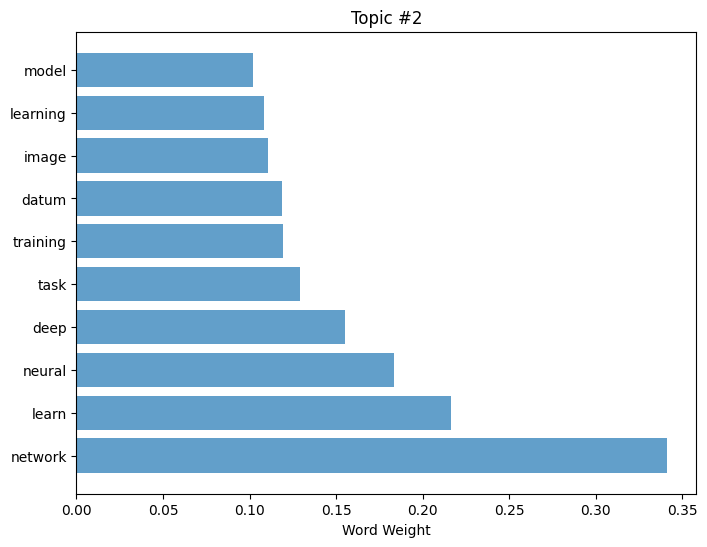

Topic #3: algorithm, problem, graph, function, matrix, optimization, solution, prove, bound, set


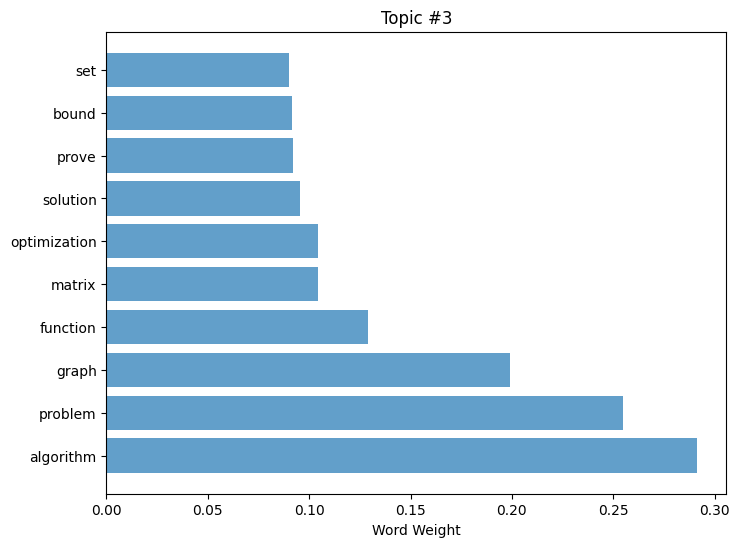

Topic #4: network, graph, group, neural, node, deep, prove, space, edge, give


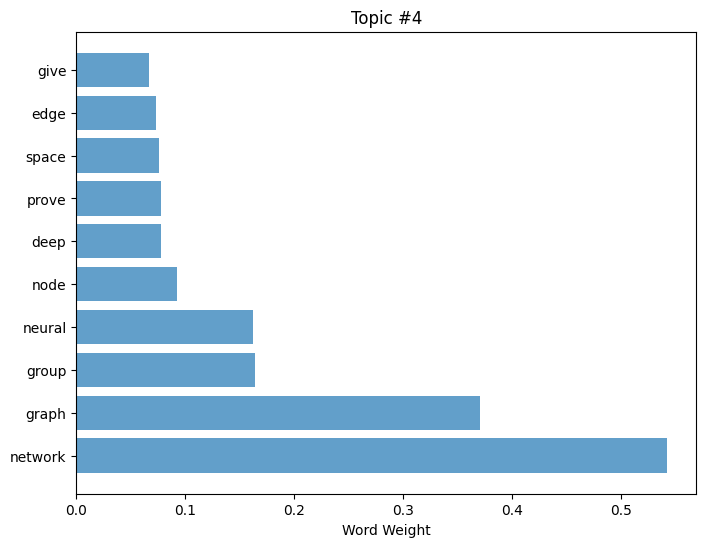

Topic #5: system, algorithm, problem, control, solution, optimization, robot, equation, solve, policy


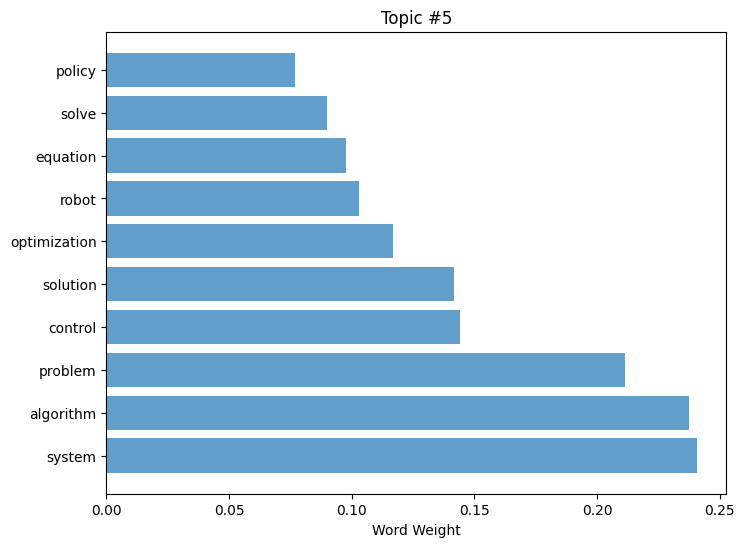

Topic #6: graph, algorithm, edge, cluster, node, vertex, time, galaxy, datum, star


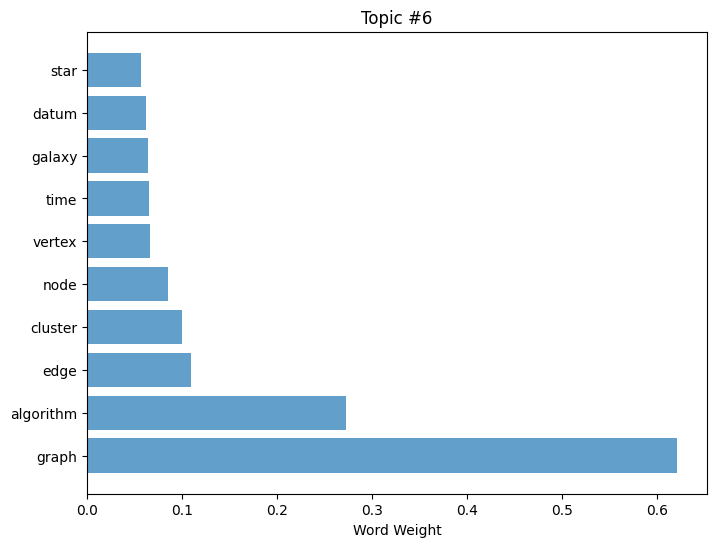

Topic #7: network, stochastic, distribution, estimator, neural, function, parameter, equation, gradient, optimization


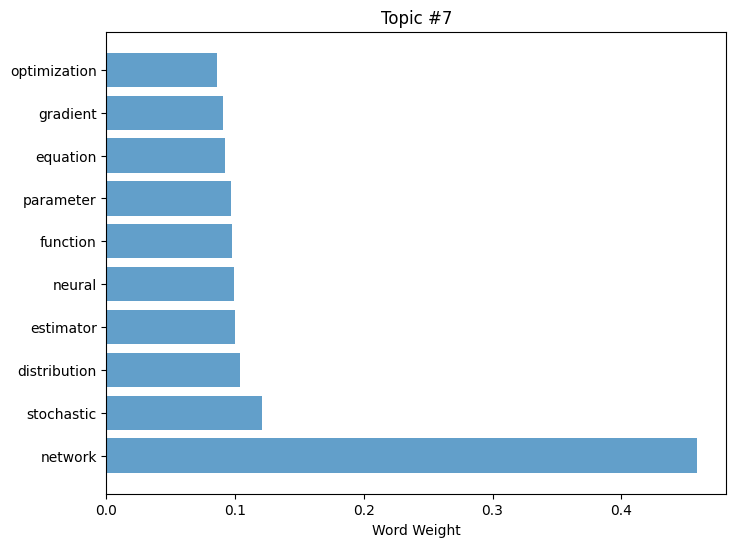

Topic #8: model, system, graph, equation, control, dynamic, solution, user, process, agent


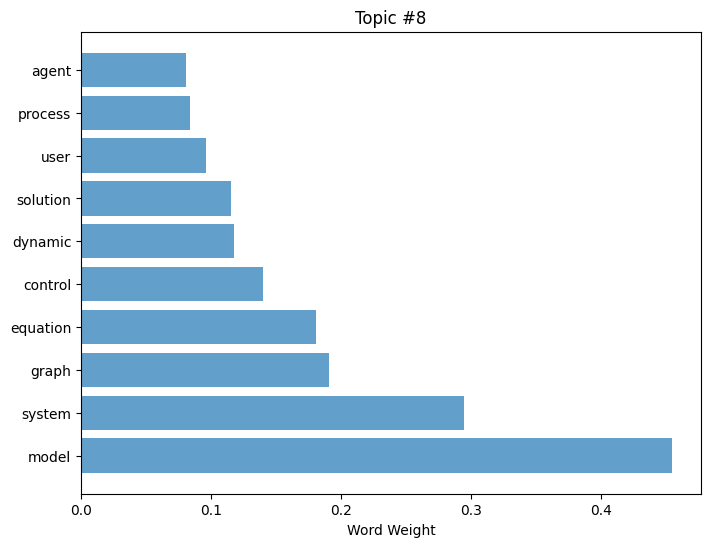

Topic #9: graph, learn, model, quantum, phase, state, spin, magnetic, transition, learning


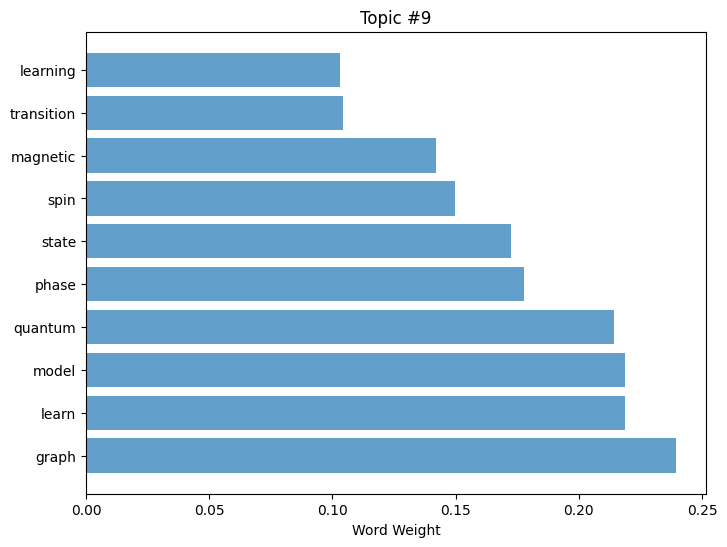

Topic #10: equation, graph, solution, image, method, nonlinear, wave, flow, differential, boundary


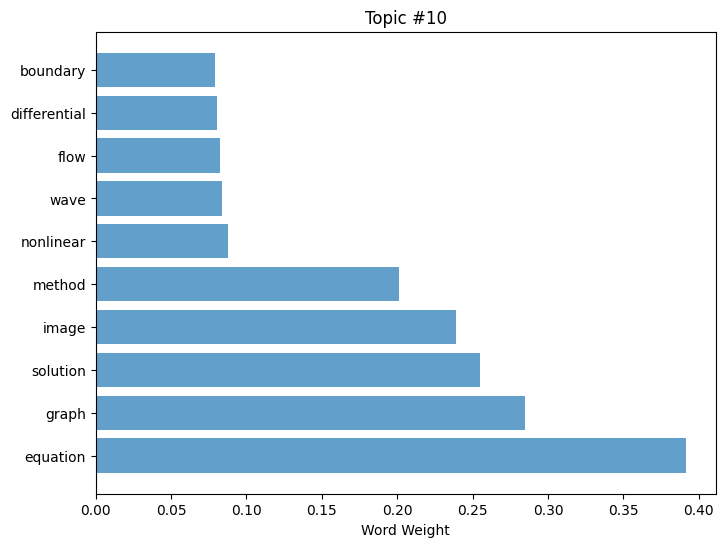

Topic #11: learn, model, galaxy, star, problem, mass, algorithm, learning, agent, deep


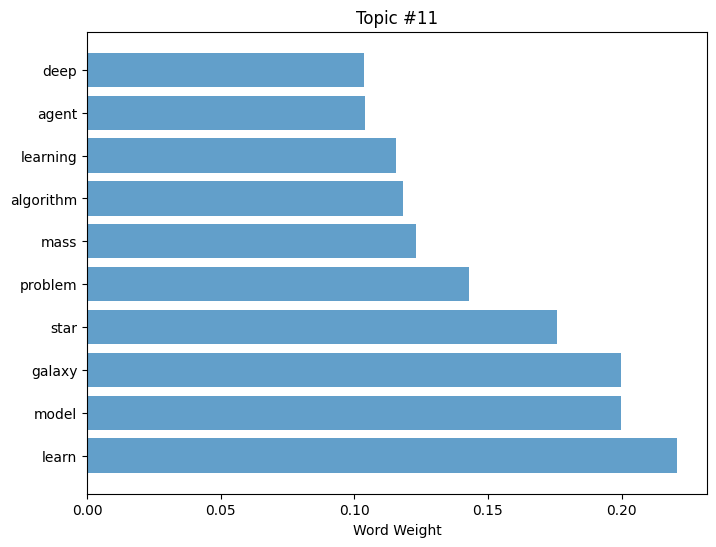

Topic #12: graph, estimator, control, function, distribution, system, policy, robot, agent, sample


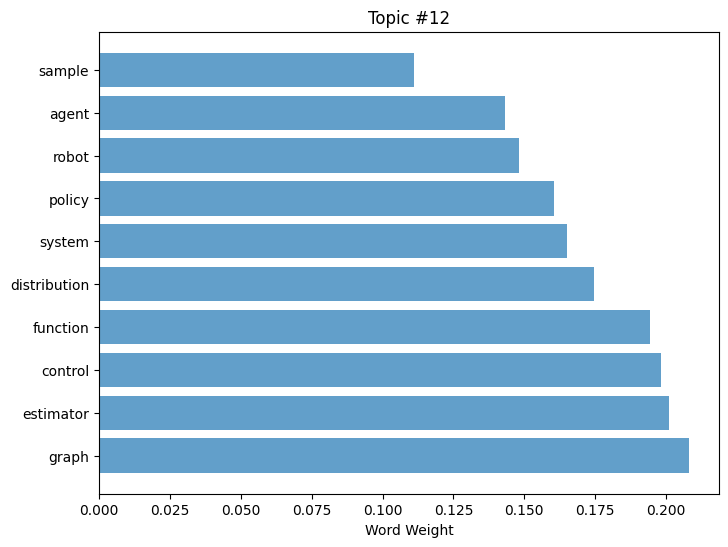

Topic #13: image, model, object, quantum, group, control, propose, code, channel, problem


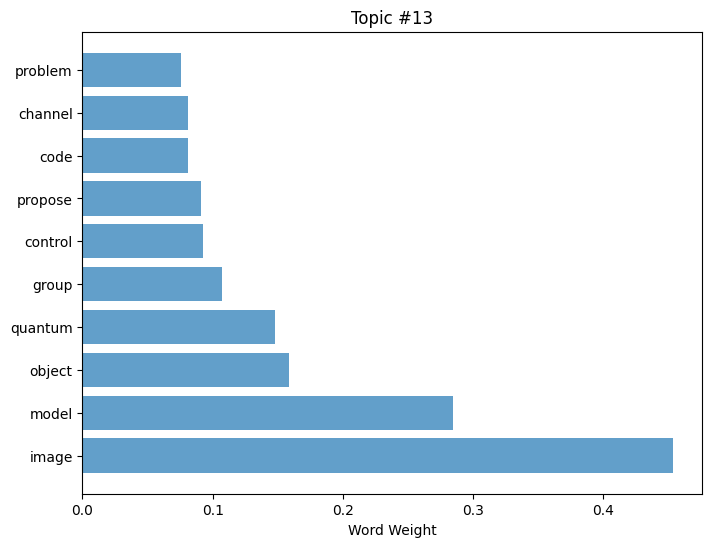

In [ ]:
def plot_top_words_per_topic(lsa_model, feature_names, n_words=10):
    topics = []
    for topic_idx, topic in enumerate(lsa_model.components_):
        top_words_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

        plt.figure(figsize=(8, 6))
        plt.barh(range(len(top_words)), topic[top_words_idx], align='center', alpha=0.7)
        plt.yticks(range(len(top_words)), top_words)
        plt.xlabel('Word Weight')
        plt.title(f'Topic #{topic_idx + 1}')
        plt.show()

    return topics

feature_names = np.array(tfidf.get_feature_names_out())

topics = plot_top_words_per_topic(lsa, feature_names)

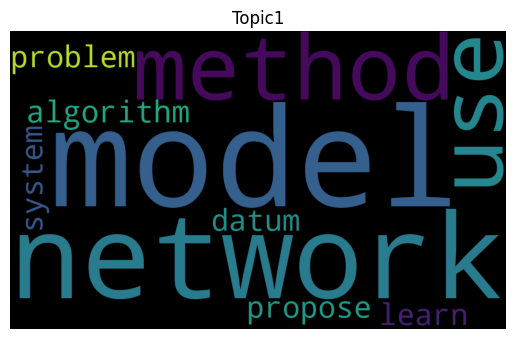

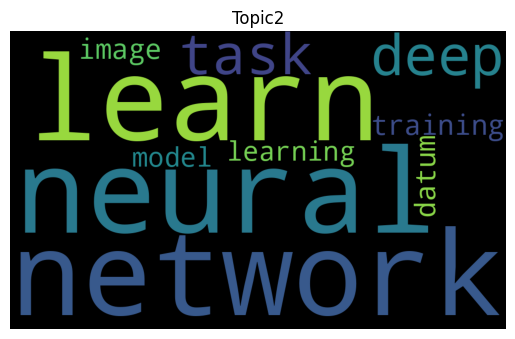

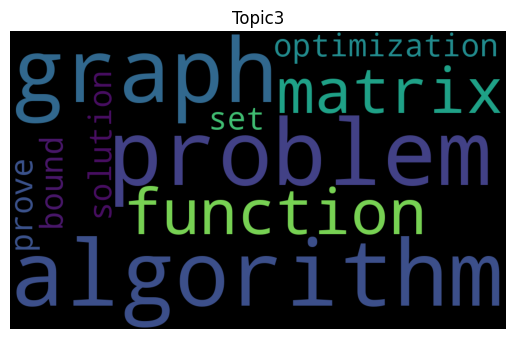

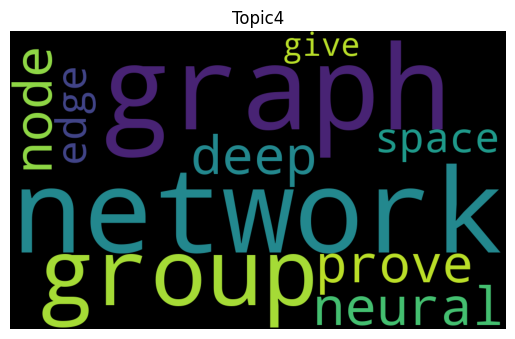

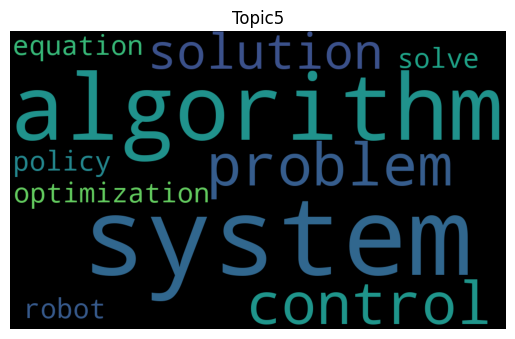

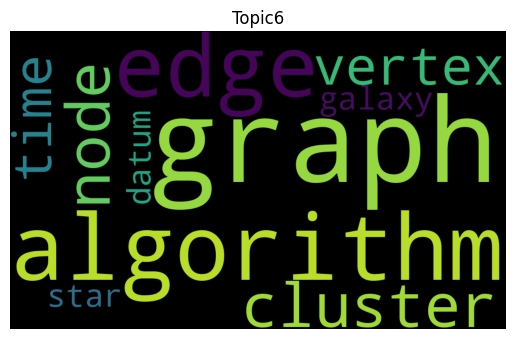

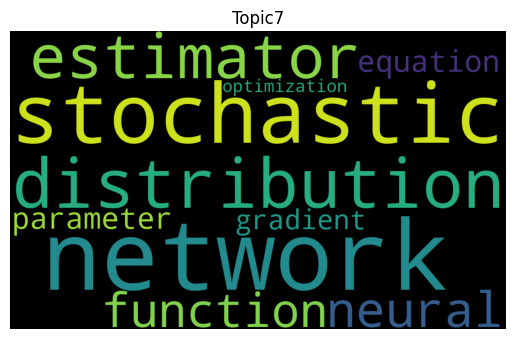

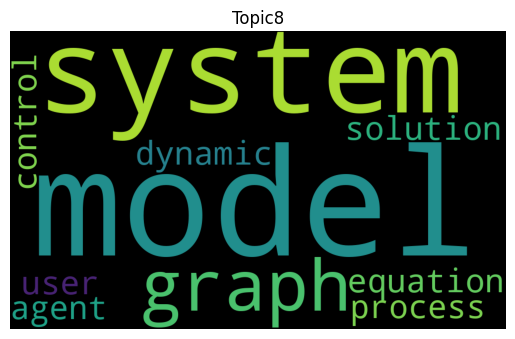

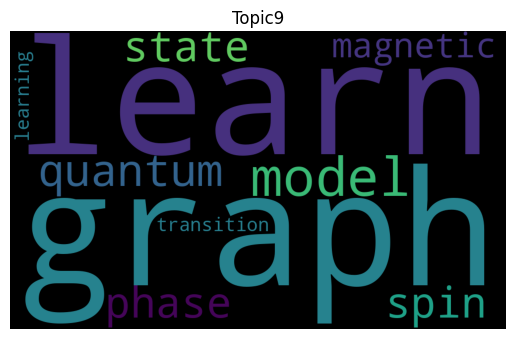

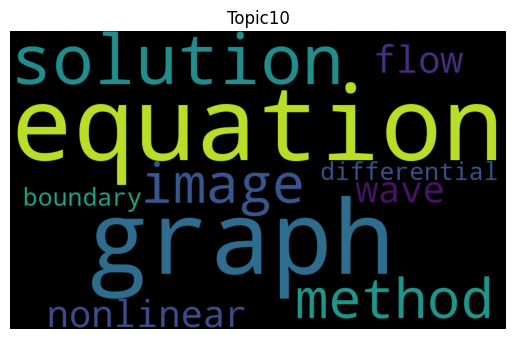

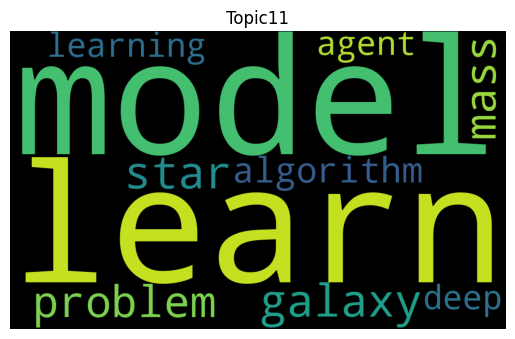

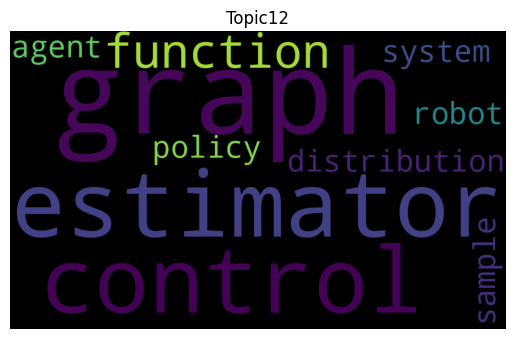

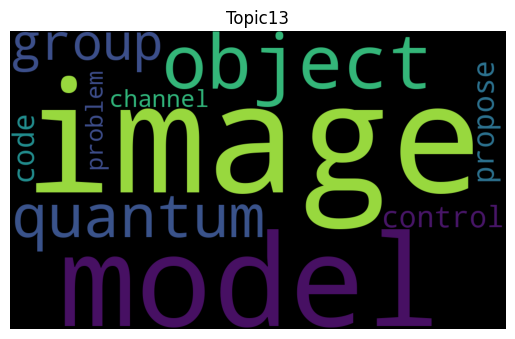

In [ ]:
H = lsa.components_
words = np.array(tfidf.get_feature_names_out())

for i, topic in enumerate(H):
  sarasas=",".join([str(x) for x in words[topic.argsort()[::-1][:10]]])
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(sarasas)
  plt.imshow(wc)
  plt.title(f"Topic{i+1}")
  plt.axis("off")
  plt.show()

In [ ]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_Cv(model, df_columnm):
  topics = model.components_

  n_top_words = 10
  texts = [[word for word in doc.split()] for doc in df_columnm]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [ ]:
get_Cv(lsa, train["clean_abstract_lemmatized"])

0.3203863331440281

Be nereikšmingų žodžių ir su pagrindinėmis formomis + CountVectorizer()

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train['clean_abstract_lemmatized'])

X = vectorizer.transform(train['clean_abstract_lemmatized'])

In [ ]:
num_topics = 13
lsa = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_result = lsa.fit_transform(X)

topics = pd.DataFrame(lsa_result, columns=[f'Topic {i+1}' for i in range(num_topics)])

Topic #1: model, use, method, network, datum, show, result, propose, problem, algorithm


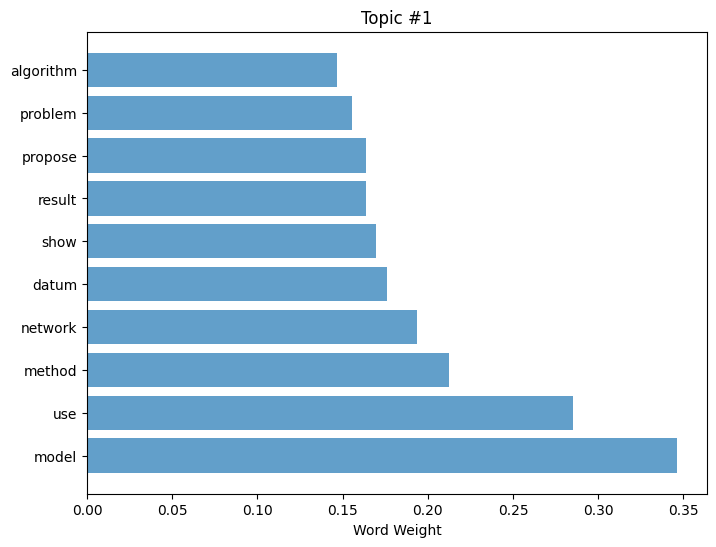

Topic #2: model, datum, network, neural, prediction, deep, inference, training, train, parameter


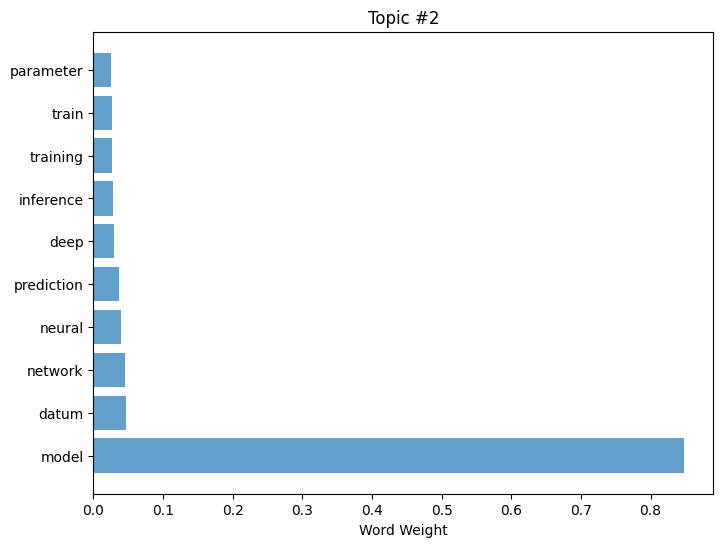

Topic #3: network, learn, neural, method, deep, propose, task, image, datum, training


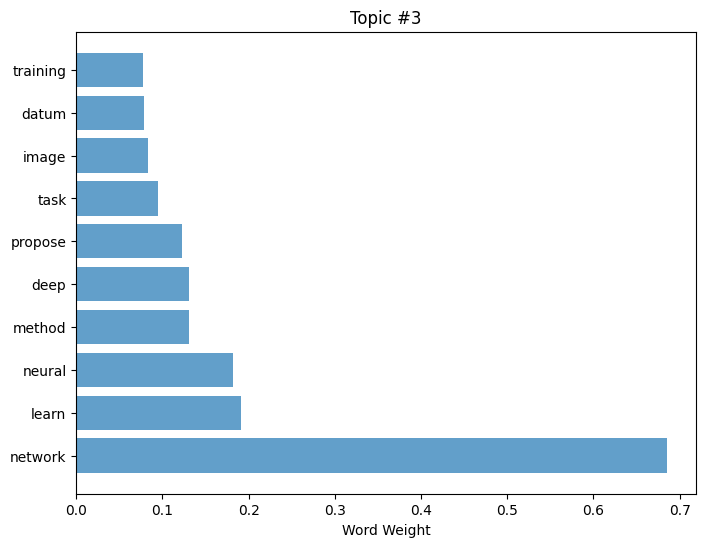

Topic #4: network, system, state, study, field, energy, phase, find, neural, magnetic


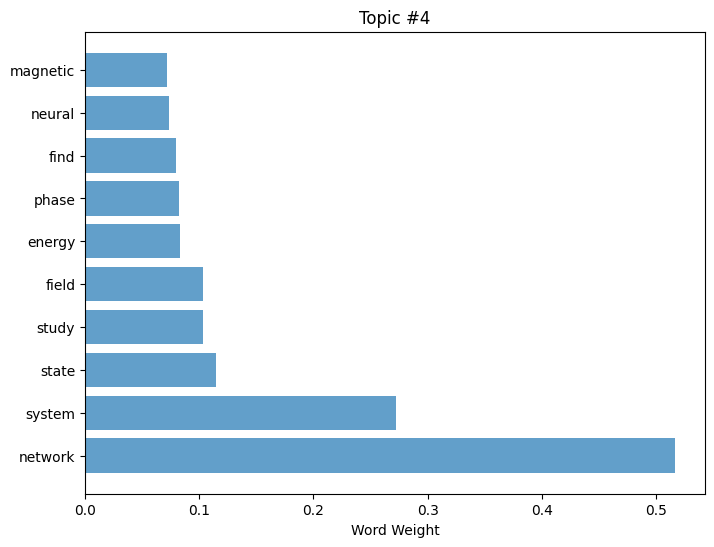

Topic #5: problem, algorithm, model, network, graph, function, give, show, solution, number


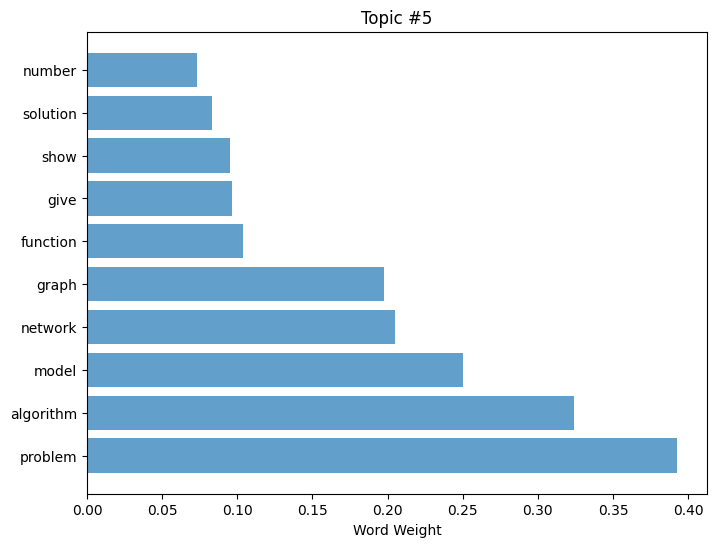

Topic #6: system, algorithm, problem, control, propose, user, approach, learn, design, task


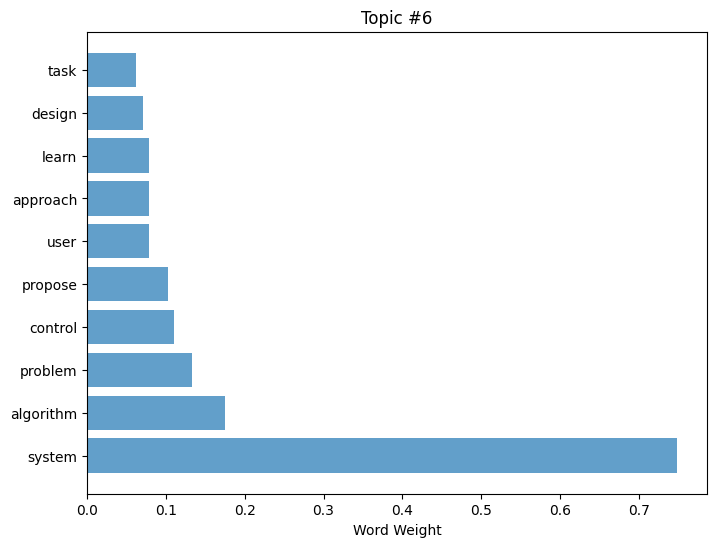

Topic #7: datum, algorithm, use, graph, set, analysis, time, data, learn, cluster


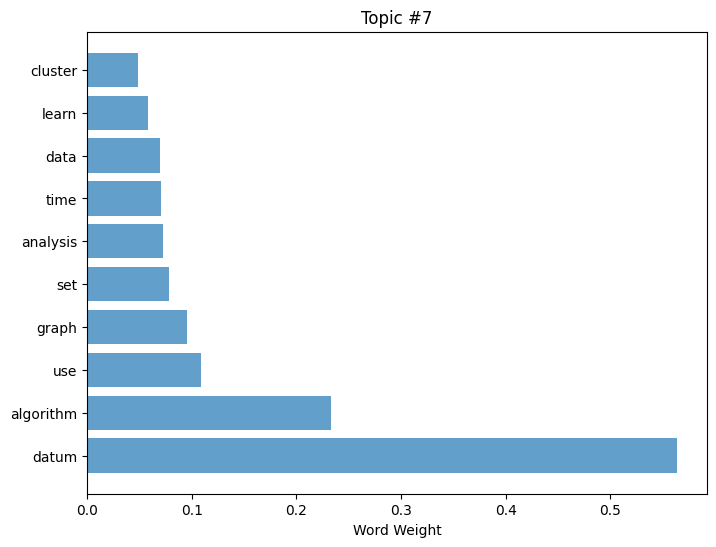

Topic #8: datum, system, method, set, problem, function, group, equation, space, study


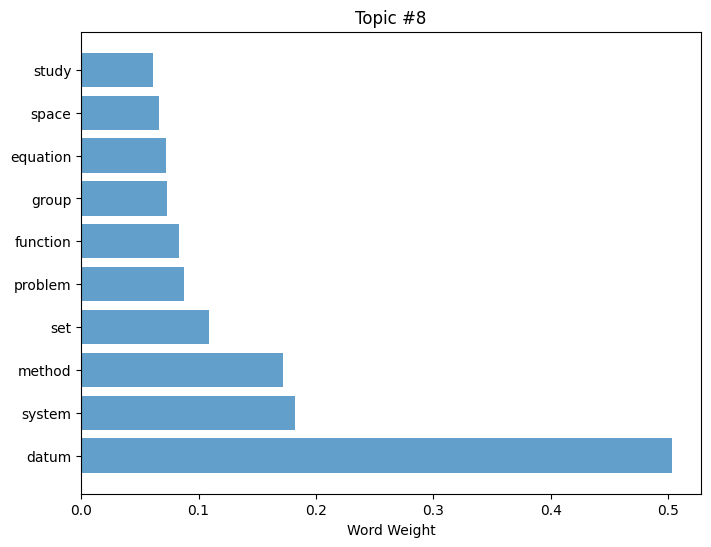

Topic #9: algorithm, method, network, time, datum, find, star, galaxy, cluster, propose


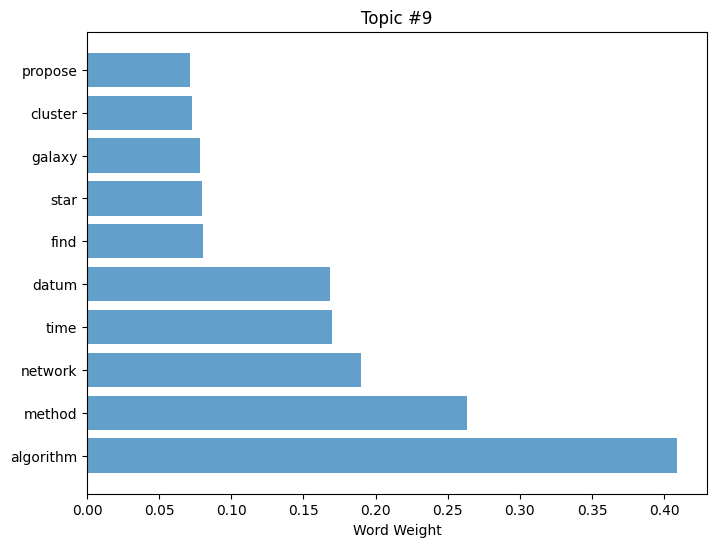

Topic #10: learn, algorithm, image, propose, field, task, deep, show, phase, learning


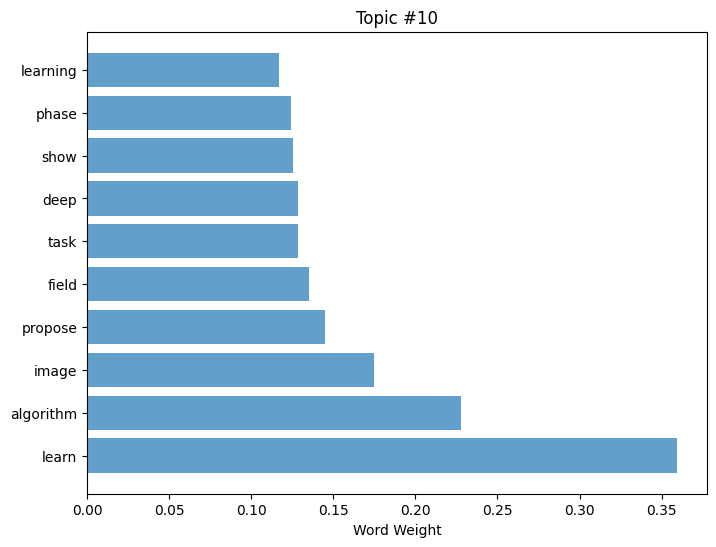

Topic #11: graph, method, group, structure, algorithm, system, result, edge, set, image


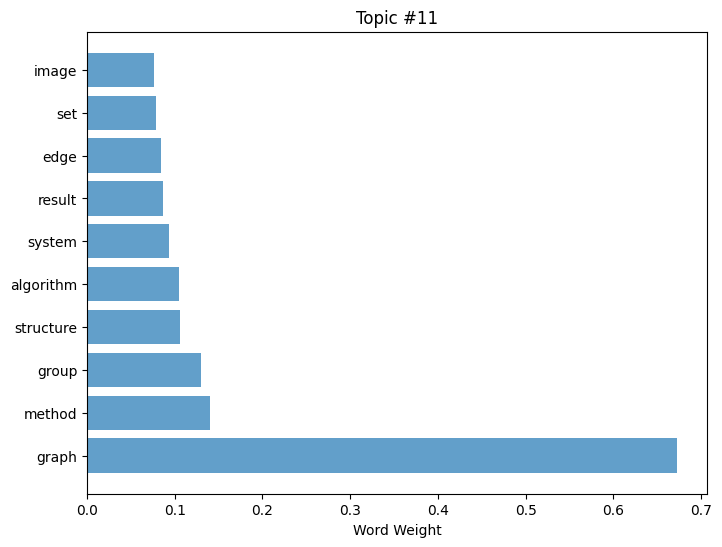

Topic #12: problem, graph, image, time, field, solution, magnetic, structure, find, solve


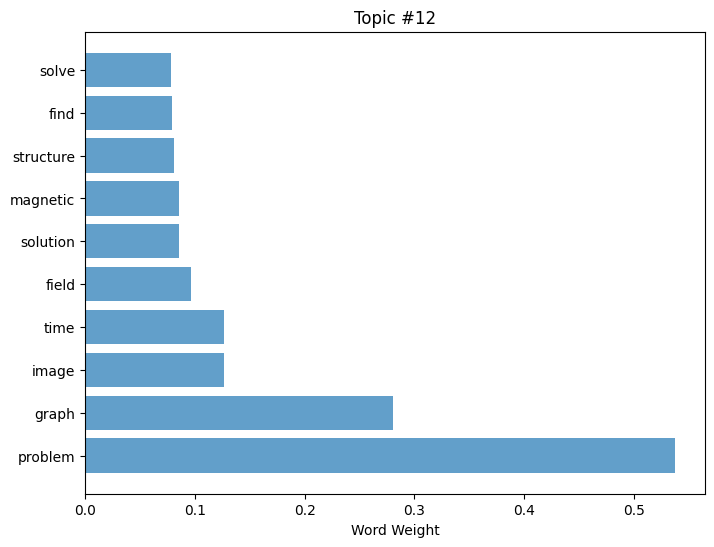

Topic #13: distribution, galaxy, star, sample, system, mass, result, problem, stellar, graph


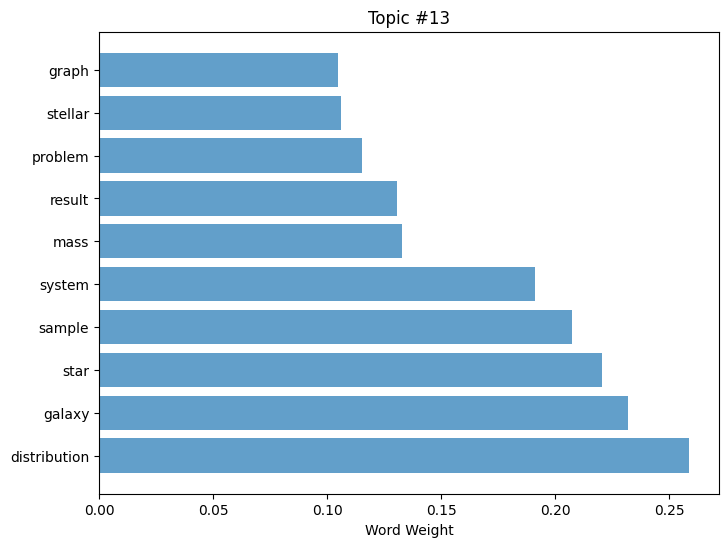

In [ ]:
def plot_top_words_per_topic(lsa_model, feature_names, n_words=10):
    topics = []
    for topic_idx, topic in enumerate(lsa_model.components_):
        top_words_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

        plt.figure(figsize=(8, 6))
        plt.barh(range(len(top_words)), topic[top_words_idx], align='center', alpha=0.7)
        plt.yticks(range(len(top_words)), top_words)
        plt.xlabel('Word Weight')
        plt.title(f'Topic #{topic_idx + 1}')
        plt.show()

    return topics

feature_names = np.array(tfidf.get_feature_names_out())

topics = plot_top_words_per_topic(lsa, feature_names)

In [ ]:
vocab = vectorizer.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
     print(" ")

Topic 0: 
model use method network datum show result propose problem algorithm  
Topic 1: 
model datum network neural prediction deep inference training train parameter  
Topic 2: 
network learn neural method deep propose task image datum training  
Topic 3: 
network system state study field energy phase find neural magnetic  
Topic 4: 
problem algorithm model network graph function give show solution number  
Topic 5: 
system algorithm problem control propose user approach learn design task  
Topic 6: 
datum algorithm use graph set analysis time data learn cluster  
Topic 7: 
datum system method set problem function group equation space study  
Topic 8: 
algorithm method network time datum find star galaxy cluster propose  
Topic 9: 
learn algorithm image propose field task deep show phase learning  
Topic 10: 
graph method group structure algorithm system result edge set image  
Topic 11: 
problem graph image time field solution magnetic structure find solve  
Topic 12: 
distribution

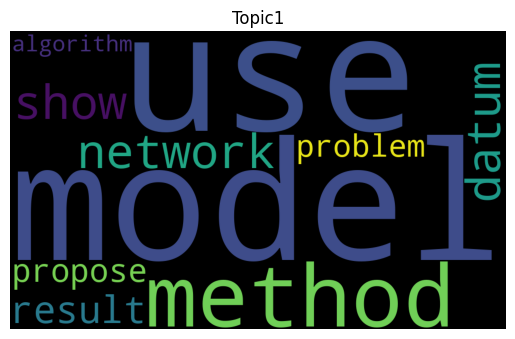

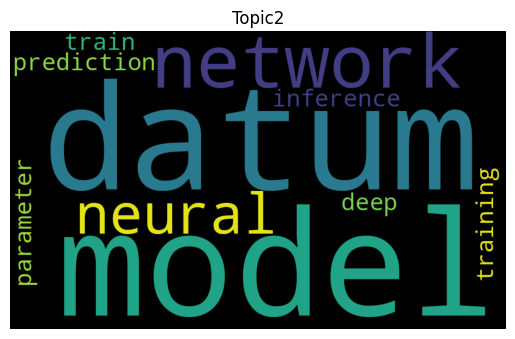

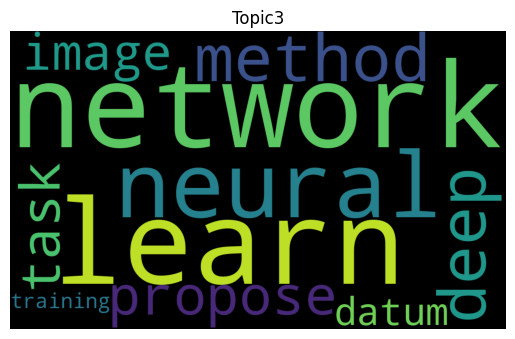

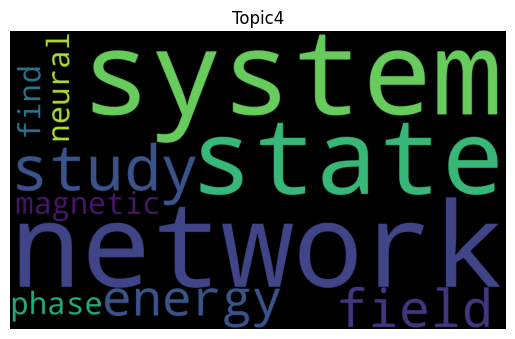

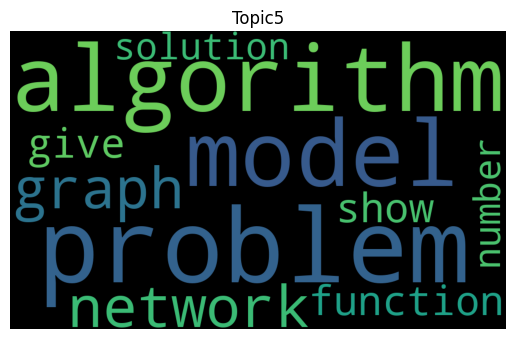

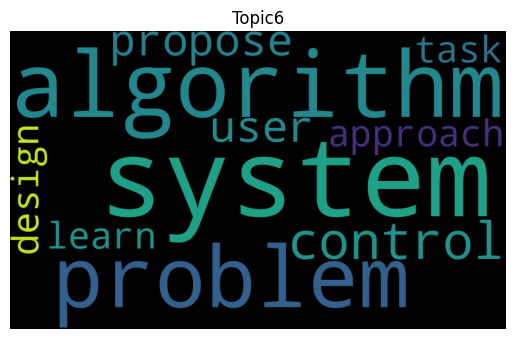

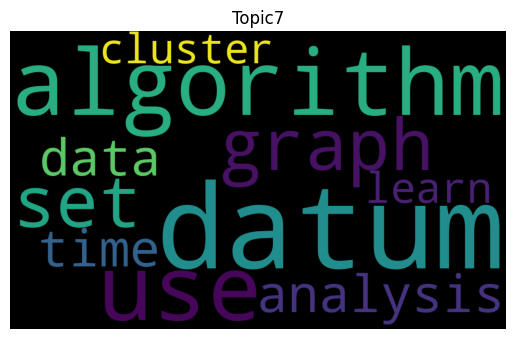

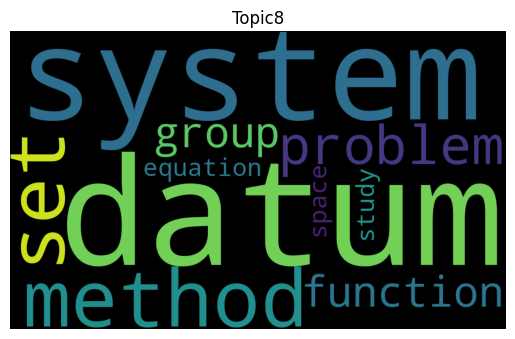

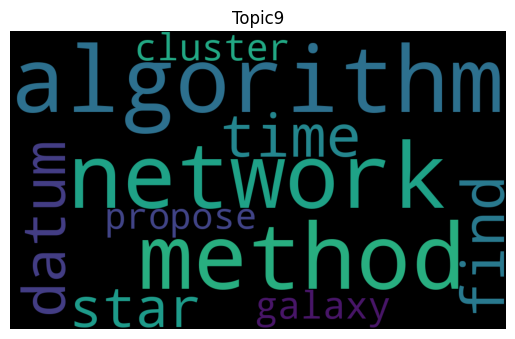

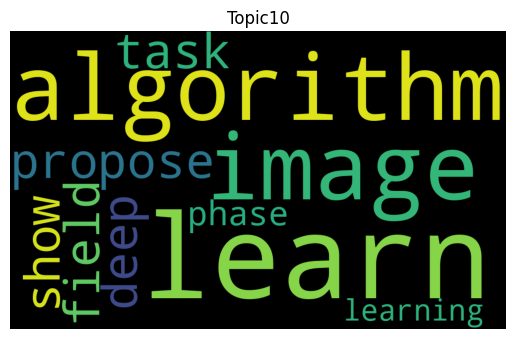

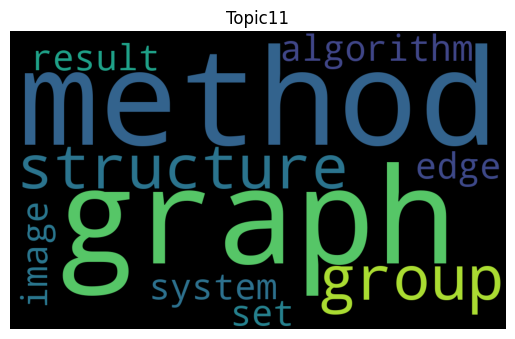

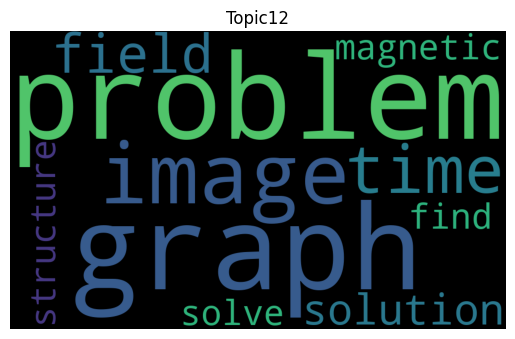

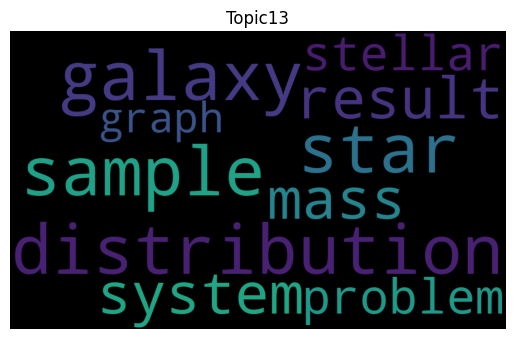

In [ ]:
H = lsa.components_
words = np.array(vectorizer.get_feature_names_out())

for i, topic in enumerate(H):
  sarasas=",".join([str(x) for x in words[topic.argsort()[::-1][:10]]])
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(sarasas)
  plt.imshow(wc)
  plt.title(f"Topic{i+1}")
  plt.axis("off")
  plt.show()

In [ ]:
get_Cv(lsa,  train["clean_abstract_lemmatized"])

0.32749560148014906

# Non-negative Matrix factorization (NMF) - pasikeiciau tema

Naudojamos nuorodos:
https://medium.com/voice-tech-podcast/topic-modelling-using-nmf-2f510d962b6e

https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/#:~:text=Topic%20Modeling%20Using%20Non%2DNegative%20Matrix%20Factorization%20(NMF),-Non%2Dnegative%20Matrix&text=Non%2Dnegative%20Matrix%20Factorization%20acts,the%20documents%20in%20the%20corpus.

https://predictivehacks.com/topic-modelling-with-nmf-in-python/


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

Atliksime tyrima:


*   Be stopwords, lematizuota ir vektorizuota Tfidf
*   Be stopwords, lematizuota ir vektorizuota count vectorizer













## be stopwords, lematized + tfidf

In [ ]:

vectorizer_nmf_tfidf = TfidfVectorizer()
X_nmf_tfidf = vectorizer_nmf_tfidf.fit_transform(train['clean_abstract_lemmatized'])

words = np.array(vectorizer_nmf_tfidf.get_feature_names_out())


In [ ]:
nmf_tfidf = NMF(n_components=13)
W_tfidf = nmf_tfidf.fit_transform(X_nmf_tfidf)
H_tfidf = nmf_tfidf.components_

for i, topic in enumerate(H_tfidf):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

Topic 1: convex,convergence,stochastic,gradient,optimal,propose,solve,optimization,problem,algorithm
Topic 2: probability,matrix,random,parameter,estimation,estimate,function,sample,estimator,distribution
Topic 3: electron,effect,state,energy,transition,temperature,spin,field,phase,magnetic
Topic 4: weight,community,convolutional,architecture,social,layer,node,deep,neural,network
Topic 5: dynamic,use,bayesian,process,parameter,latent,datum,prediction,inference,model
Topic 6: structure,subgraph,number,graphs,vertice,random,node,vertex,edge,graph
Topic 7: theory,theorem,set,manifold,finite,function,give,prove,space,group
Topic 8: approach,paper,dynamic,information,use,robot,design,user,control,system
Topic 9: qubit,phase,classical,matrix,entanglement,topological,theory,system,state,quantum
Topic 10: wave,condition,numerical,operator,problem,differential,boundary,nonlinear,solution,equation
Topic 11: dark,emission,formation,gas,planet,stellar,mass,cluster,star,galaxy
Topic 12: feature,tra

In [ ]:
import matplotlib.pyplot as plt

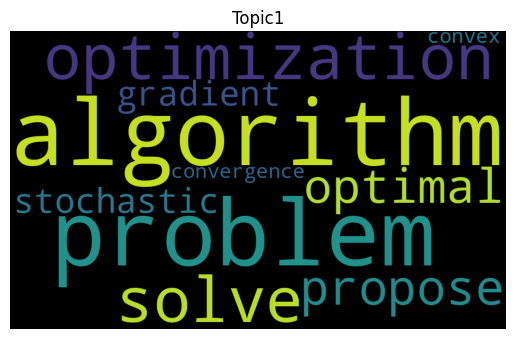

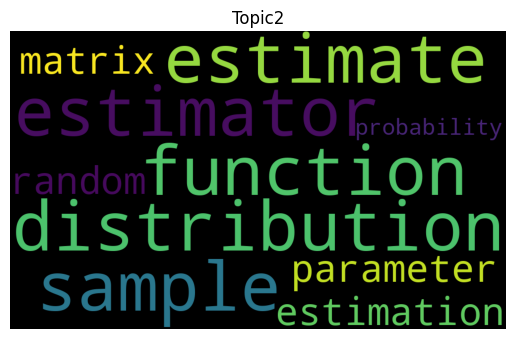

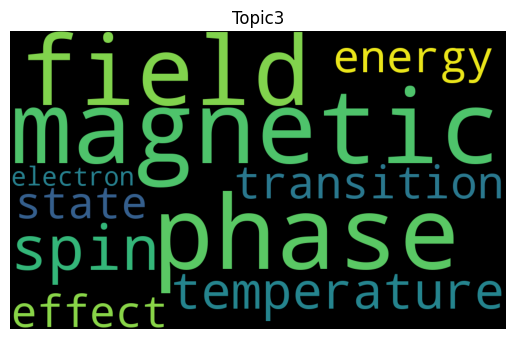

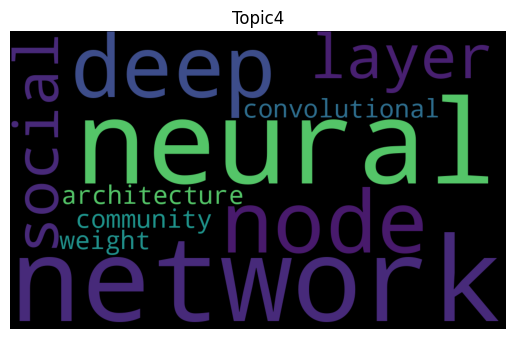

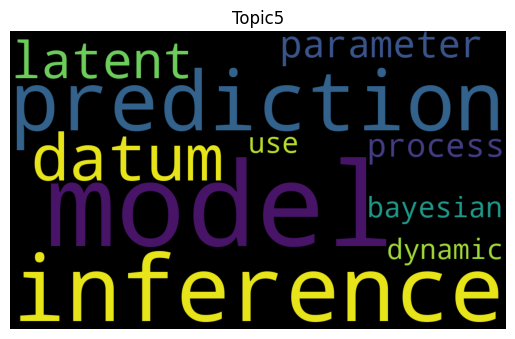

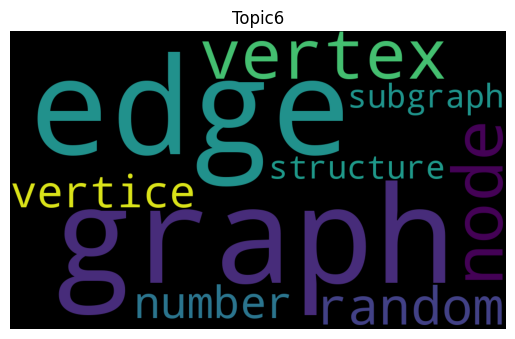

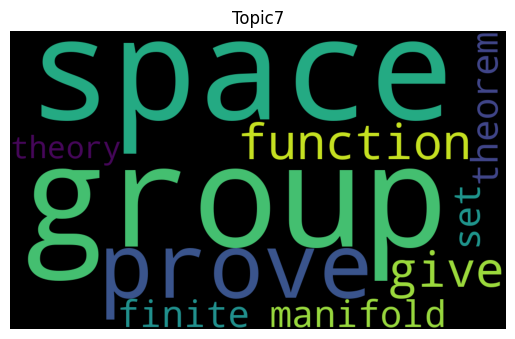

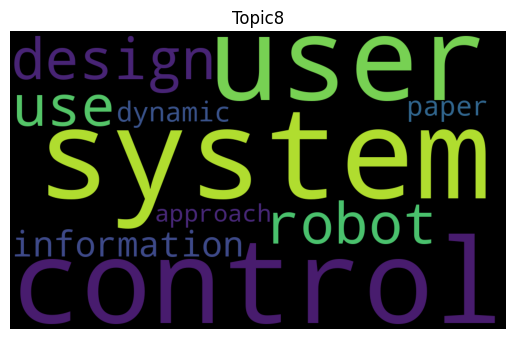

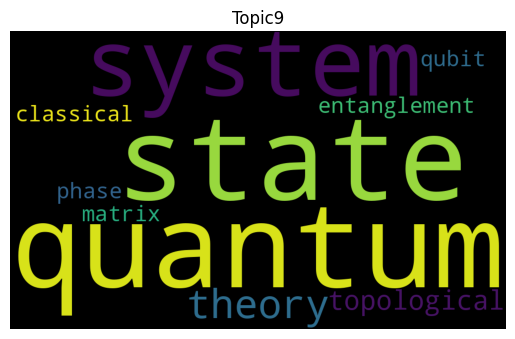

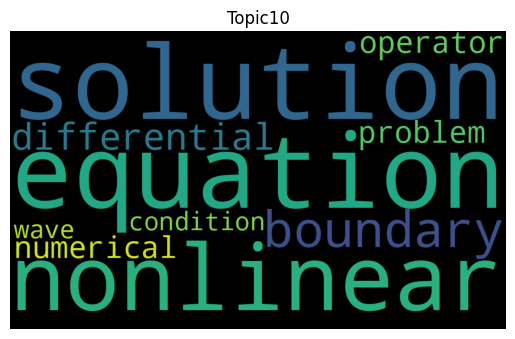

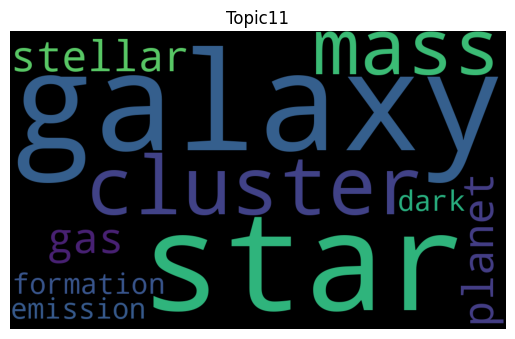

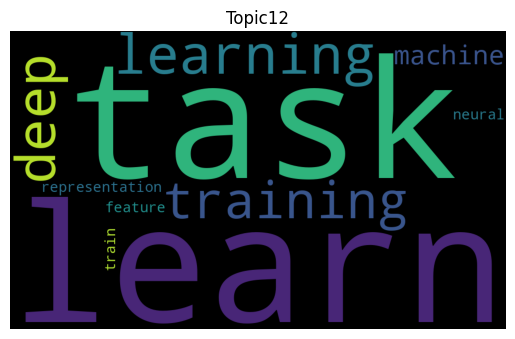

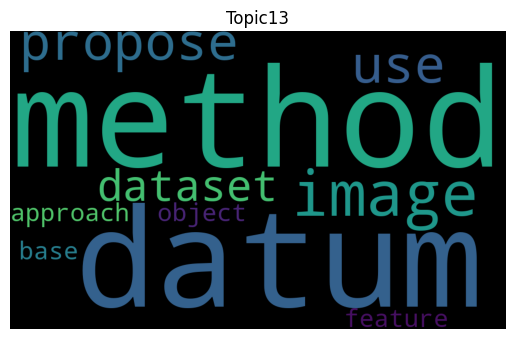

In [ ]:
for i, topic in enumerate(H_tfidf):
  sarasas=",".join([str(x) for x in  words[topic.argsort()[::-1][:10]]])
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(sarasas)
  plt.imshow(wc)
  plt.title(f"Topic{i+1}")
  plt.axis("off")
  plt.show()

In [ ]:
components_df = pd.DataFrame(nmf_tfidf.components_, columns=vectorizer_nmf_tfidf.get_feature_names_out())


In [ ]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
algorithm       2.827789
problem         1.855319
optimization    0.997114
solve           0.583063
propose         0.494915
optimal         0.486438
gradient        0.482541
stochastic      0.475374
convergence     0.447044
convex          0.435213
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
distribution    1.180237
estimator       0.981358
sample          0.835582
function        0.559589
estimate        0.557864
estimation      0.509269
parameter       0.481775
random          0.446830
matrix          0.417255
probability     0.388331
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
magnetic       0.937085
phase          0.795957
field          0.754905
spin           0.649523
temperature    0.648728
transition     0.523953
energy         0.511951
state          0.476015
effect         0.415492
electron       0.399230
Name: 2, dtype: float64


For topic 4 the words with the h

## be stopwords + lemmatized + countvectorizer algoritmas

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:

vectorizer_nmf_cv = CountVectorizer()
X_nmf_cv = vectorizer_nmf_cv.fit_transform(train['clean_abstract_lemmatized'])

words = np.array(vectorizer_nmf_cv.get_feature_names_out())

In [ ]:
nmf_cv = NMF(n_components=13)
W_cv = nmf_cv.fit_transform(X_nmf_cv)
H_cv = nmf_cv.components_

for i, topic in enumerate(H_cv):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

Topic 1: information,application,sample,time,provide,approach,set,data,analysis,datum
Topic 2: variable,bayesian,dynamic,distribution,inference,prediction,propose,process,parameter,model
Topic 3: show,architecture,layer,information,structure,social,node,deep,neural,network
Topic 4: temperature,effect,transition,study,quantum,energy,magnetic,phase,state,field
Topic 5: efficient,paper,new,number,performance,show,base,time,propose,algorithm
Topic 6: base,time,propose,present,design,user,dynamic,paper,control,system
Topic 7: paper,matrix,demonstrate,sample,apply,estimate,new,base,propose,method
Topic 8: performance,test,base,design,information,present,technique,result,approach,use
Topic 9: case,study,also,set,group,space,give,show,result,function
Topic 10: training,dataset,approach,learning,feature,deep,propose,task,image,learn
Topic 11: vertice,give,random,set,node,vertex,structure,number,edge,graph
Topic 12: set,consider,control,approach,time,optimal,optimization,solve,solution,problem
T

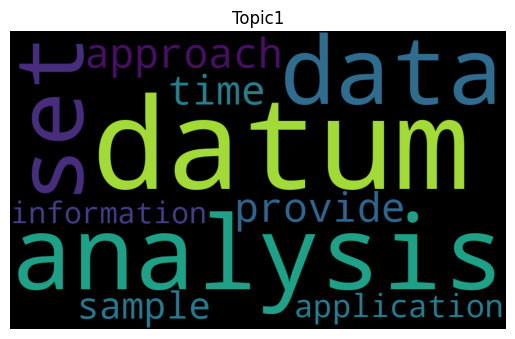

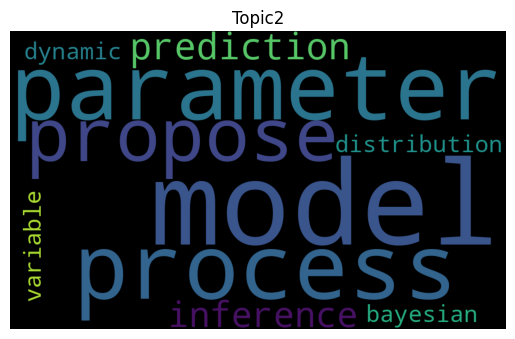

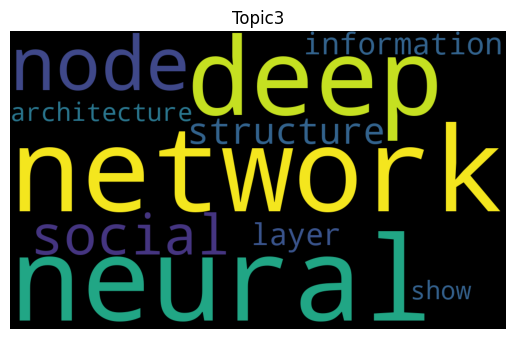

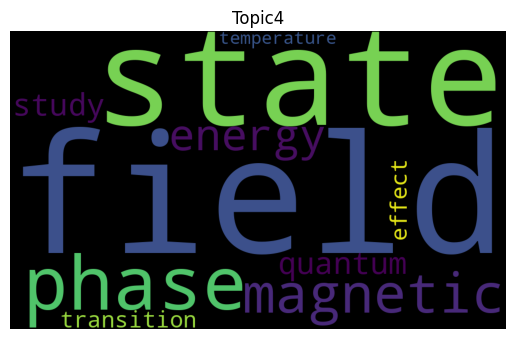

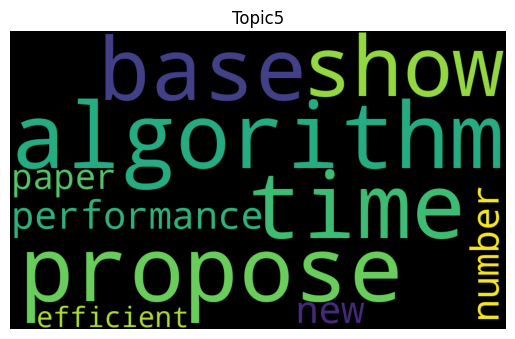

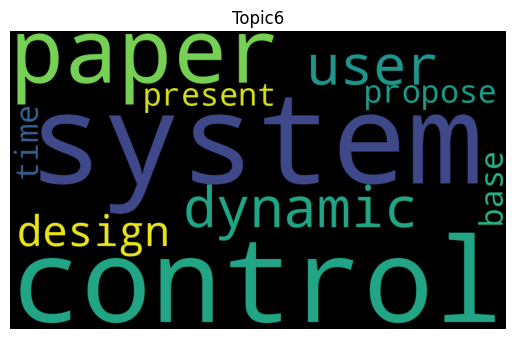

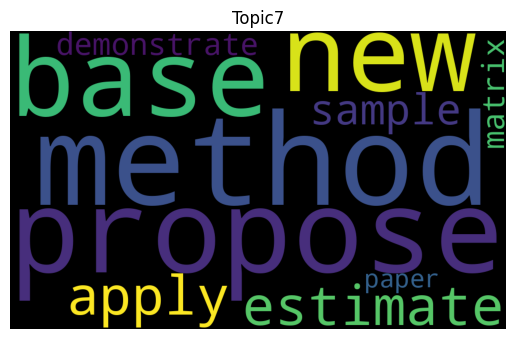

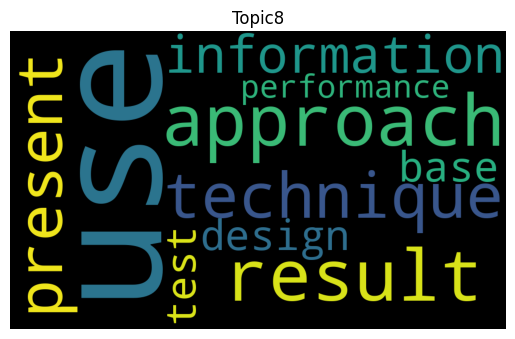

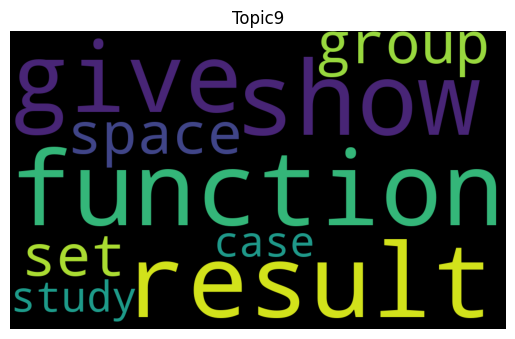

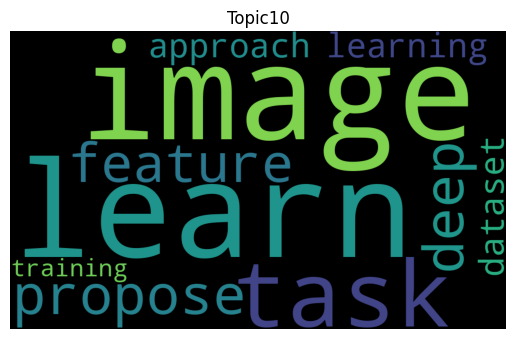

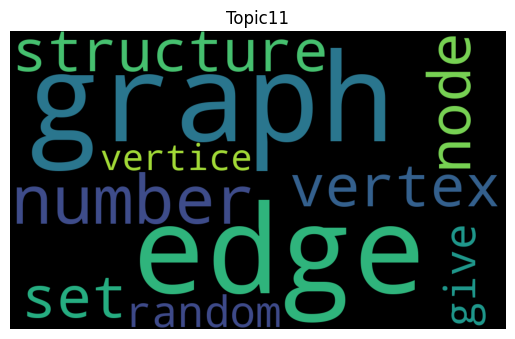

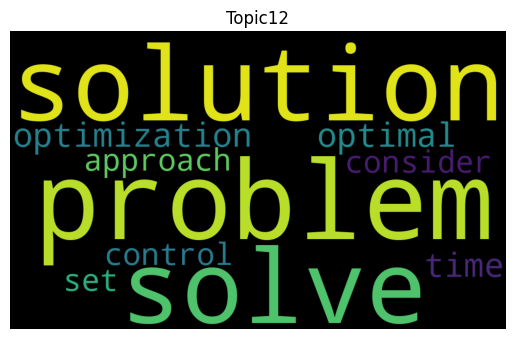

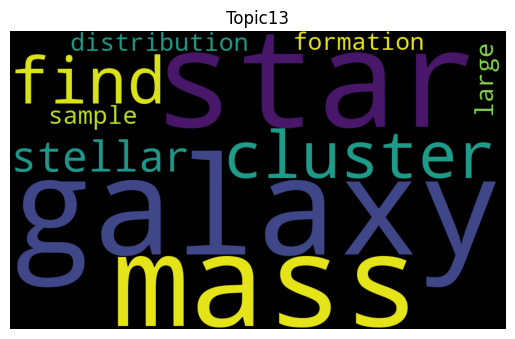

In [ ]:
for i, topic in enumerate(H_cv):
  sarasas=",".join([str(x) for x in  words[topic.argsort()[::-1][:10]]])
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(sarasas)
  plt.imshow(wc)
  plt.title(f"Topic{i+1}")
  plt.axis("off")
  plt.show()

In [ ]:
components_df_cv = pd.DataFrame(nmf_cv.components_, columns=vectorizer_nmf_cv.get_feature_names_out())


In [ ]:
for topic in range(components_df_cv.shape[0]):
    tmp = components_df_cv.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
datum          17.389663
analysis        2.232547
data            2.069923
set             1.713254
approach        1.172511
provide         1.034861
time            1.008581
sample          0.898378
application     0.884955
information     0.878610
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
model           14.974369
parameter        0.890412
process          0.617973
propose          0.578265
prediction       0.573304
inference        0.544464
distribution     0.492775
dynamic          0.474490
bayesian         0.409810
variable         0.368524
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
network         13.970359
neural           2.459226
deep             1.042293
node             0.922101
social           0.891004
structure        0.671806
information      0.666155
layer            0.574628
architecture     0.545650
show             0.517772
Name: 2, dtype: float64


Fo

Ivertinimas
https://radimrehurek.com/gensim/models/coherencemodel.html

Topic coherence is a way to judge the quality of topics via a single quantitative, scalar value. There are many ways to compute the coherence score. For the u_mass and c_v options, a higher is always better. Note that u_mass is between -14 and 14 and c_v is between 0 and 1. https://datascience.oneoffcoder.com/topic-modeling-gensim.html

https://stackoverflow.com/questions/66877729/calculate-coherence-for-non-gensim-topic-model

In [ ]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_Cv(model, df_columnm):
  topics = model.components_

  n_top_words = 10
  texts = [[word for word in doc.split()] for doc in df_columnm]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [ ]:
get_Cv(nmf_cv, train["clean_abstract_lemmatized"])

0.5967918576149951

In [ ]:
get_Cv(nmf_tfidf,  train["clean_abstract_lemmatized"])

0.5839509663547878

# BERTopic

Be nereikšmingų žodžių ir su pagrindinėmis formomis + TfidfVectorizer()

In [ ]:

vectorizer_model_1 = TfidfVectorizer()


In [ ]:
!pip install bertopic

In [ ]:
from bertopic import BERTopic
model = BERTopic(verbose=True,
                 language="english",
                 nr_topics = 14,
                 vectorizer_model = vectorizer_model_1)
headline_topics, _ = model.fit_transform(train['clean_abstract_lemmatized'])


In [ ]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq

Number of topics: 14


Topic  Count                                   Name  \
0      -1   9138               -1_model_use_method_show   
1       0   2699               0_user_use_network_model   
2       1   2519              1_model_network_learn_use   
3       2   1076            2_group_prove_give_category   
4       3   1069           3_galaxy_star_stellar_planet   
5       4   1025       4_algorithm_method_datum_problem   
6       5    936     5_equation_solution_system_control   
7       6    759          6_magnetic_quantum_spin_phase   
8       7    475         7_graph_network_algorithm_edge   
9       8    401       8_protein_model_epidemic_disease   
10      9    329    9_graphene_fracture_energy_electron   
11     10    290      10_curvature_space_operator_ricci   
12     11    244         11_optical_laser_photonic_atom   
13     12     12  12_memristor_memristive_rram_crossbar   

                                       Representation  \
0   [model, use, method, show, problem, algorithm,...   
1   [user, use, network, model, propose, algorithm...   
2   [model, network, learn, use, neural, propose, ...   
3   [group, prove, give, category, algebra, space,...   
4   [galaxy, star, stellar, planet, mass, emission...   
5   [algorithm, method, datum, problem, matrix, es...   
6   [equation, solution, system, control, flow, pr...   
7   [magnetic, quantum, spin, phase, state, superc...   
8   [graph, network, algorithm, edge, problem, com...   
9   [protein, model, epidemic, disease, gene, netw...   
10  [graphene, fracture, energy, electron, materia...   
11  [curvature, space, operator, ricci, metric, ma...   
12  [optical, laser, photonic, atom, waveguide, ca...   
13  [memristor, memristive, rram, crossbar, curren...   

                                  Representative_Docs  
0   [challenge take many variable account optimiza...  
1   [various economic environment people observe s...  
2   [deep learning become state art approach many ...  
3   [article construct three explicit natural subg...  
4   [mass function galaxy cluster sensitive tracer...  
5   [paper consider general matrix factorization m...  
6   [boundary value problem complete second order ...  
7   [report magnetic thermodynamic property mo mag...  
8   [study timevarye dynamic network graphs fundam...  
9   [study challenge apply deep learn gene express...  
10  [direct growth graphene semiconducting insulat...  
11  [show form connected sum homotopy sphere jconn...  
12  [scalable quantum photonic system require effi...  
13  [interest memristor rise due possible applicat...

In [ ]:
model.get_topic(0)  # Select the most frequent topic

[('user', 0.01787244222290855),
 ('use', 0.017497713506786607),
 ('network', 0.01734882021080961),
 ('model', 0.016818887299401324),
 ('propose', 0.016168990721299147),
 ('algorithm', 0.015888053354321453),
 ('datum', 0.014787672379766059),
 ('system', 0.01434315956649796),
 ('policy', 0.014220283125961103),
 ('paper', 0.014081768181181134)]

In [ ]:
model.visualize_barchart(top_n_topics=13)

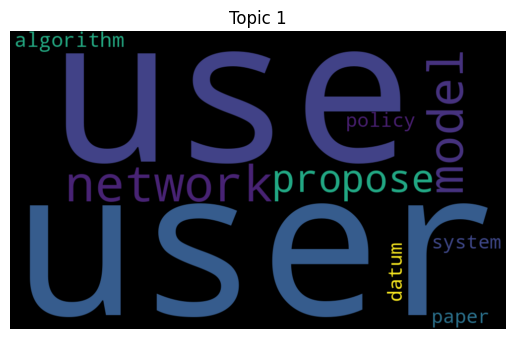

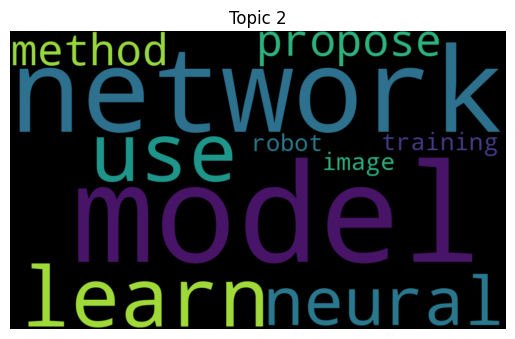

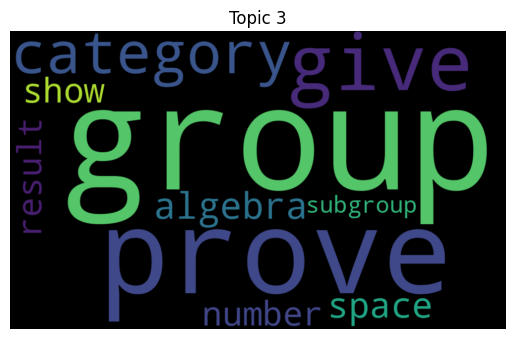

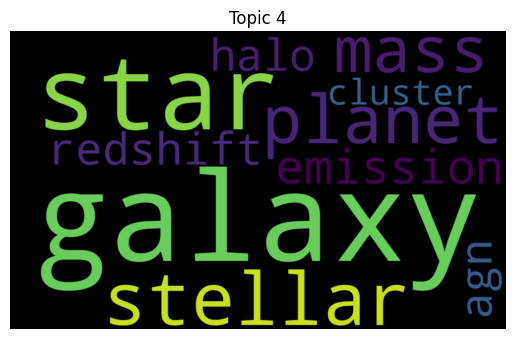

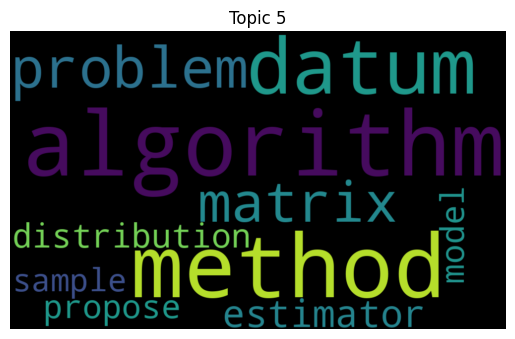

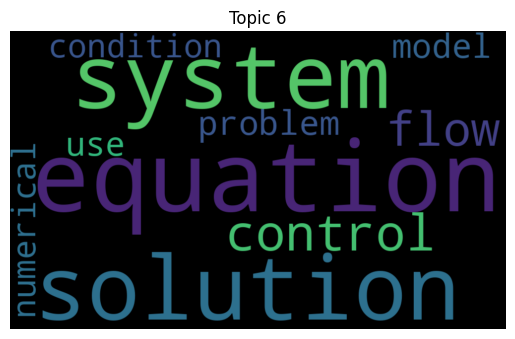

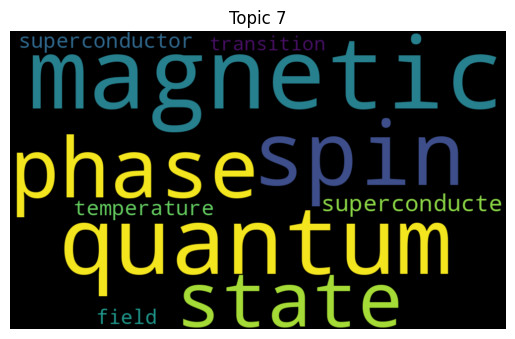

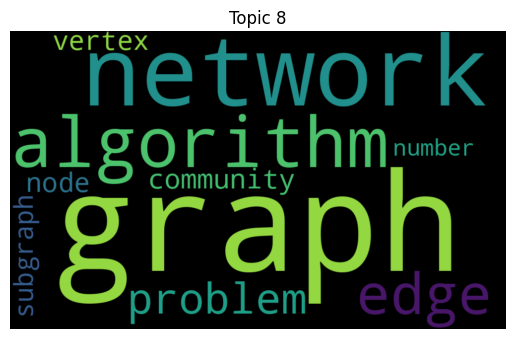

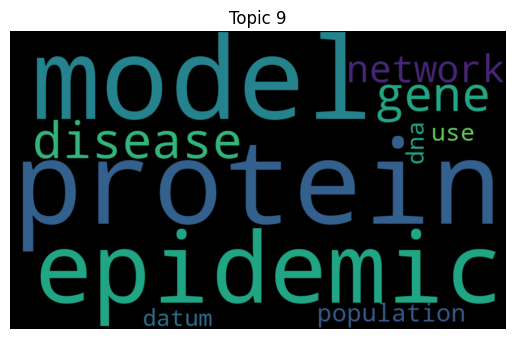

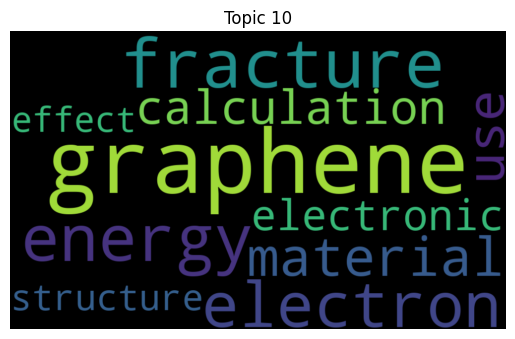

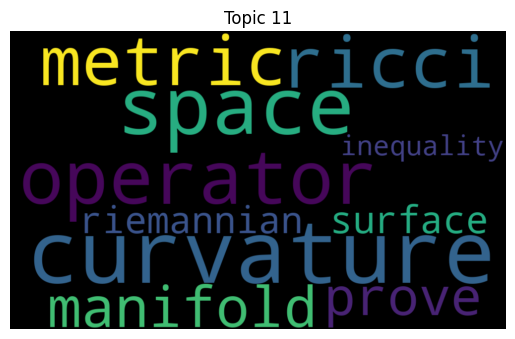

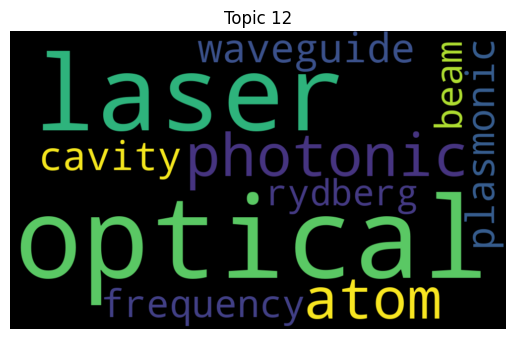

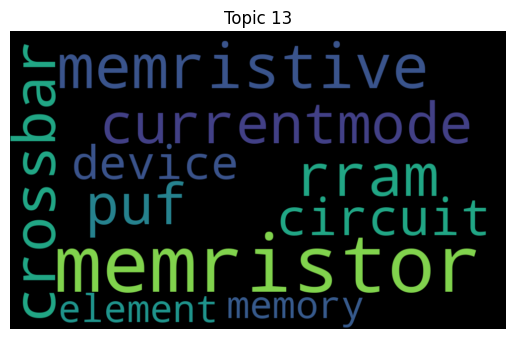

In [ ]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color="black", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic + 1}")
    plt.show()

#create_wordcloud(model, topic=1)
for topic in range(13):
    create_wordcloud(model, topic)

In [ ]:
vectorizer = model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in train['clean_abstract_lemmatized']]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in model.get_topic(topic)]
               for topic in range(len(set(headline_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.5749851656033977


In [ ]:
vectorizer = model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in train['clean_abstract_lemmatized']]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in model.get_topic(topic)]
               for topic in range(len(set(headline_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='u_mass')
coherence = coherence_model.get_coherence()
print(coherence)

-2.8288364290952503


Be nereikšmingų žodžių ir su pagrindinėmis formomis + CountVectorizer()

In [ ]:
vectorizer_model_2 = CountVectorizer()

In [ ]:
model_2 = BERTopic(verbose=True,
                 language="english",
                 nr_topics = 14,
                 vectorizer_model = vectorizer_model_2)
headline_topics, _ = model_2.fit_transform(train['clean_abstract_lemmatized'])


Batches:   0%|          | 0/656 [00:00<?, ?it/s]

2023-11-18 15:44:07,524 - BERTopic - Transformed documents to Embeddings
2023-11-18 15:44:28,640 - BERTopic - Reduced dimensionality
2023-11-18 15:44:31,812 - BERTopic - Clustered reduced embeddings
2023-11-18 15:44:41,062 - BERTopic - Reduced number of topics from 234 to 14


In [ ]:
freq = model_2.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq

Number of topics: 14


Topic  Count                                    Name  \
0      -1   8916                -1_model_use_result_show   
1       0   3373              0_network_model_use_method   
2       1   2342          1_use_algorithm_system_propose   
3       2   1394        2_method_algorithm_problem_model   
4       3   1273             3_group_prove_algebra_logic   
5       4    955              4_galaxy_star_mass_stellar   
6       5    841           5_quantum_magnetic_state_spin   
7       6    817      6_equation_control_solution_system   
8       7    374                 7_flow_energy_fluid_use   
9       8    260        8_graphene_material_optical_band   
10      9    182   9_image_imaging_method_reconstruction   
11     10    121           10_channel_relay_antenna_user   
12     11    112        11_prime_function_integer_number   
13     12     12  12_memristor_device_memristive_circuit   

                                       Representation  \
0   [model, use, result, show, method, problem, da...   
1   [network, model, use, method, graph, propose, ...   
2   [use, algorithm, system, propose, model, probl...   
3   [method, algorithm, problem, model, matrix, pr...   
4   [group, prove, algebra, logic, show, give, spa...   
5   [galaxy, star, mass, stellar, find, cluster, f...   
6   [quantum, magnetic, state, spin, phase, field,...   
7   [equation, control, solution, system, space, o...   
8   [flow, energy, fluid, use, simulation, model, ...   
9   [graphene, material, optical, band, device, st...   
10  [image, imaging, method, reconstruction, use, ...   
11  [channel, relay, antenna, user, power, network...   
12  [prime, function, integer, number, integral, p...   
13  [memristor, device, memristive, circuit, cross...   

                                  Representative_Docs  
0   [compute integral function expectation random ...  
1   [interpretability deep neural network recently...  
2   [paper propose novel rank framework collaborat...  
3   [article investigate large sample property mod...  
4   [introduce notion depth finite group g define ...  
5   [present millimetre dust emission measurement ...  
6   [antiferromagnetic ising chain transverse long...  
7   [study optimal boundary control problem twodim...  
8   [numerical experimental turbulence simulation ...  
9   [tune band gap twodimensional material great i...  
10  [inherent noise observe eg scan binary documen...  
11  [paper concerned channel estimation problem mu...  
12  [paper use refined approximation chebyshevs va...  
13  [interest memristor rise due possible applicat...

In [ ]:
model_2.get_topic(0)  # Select the most frequent topic

[('network', 0.03569753226795524),
 ('model', 0.02958440815853431),
 ('use', 0.02217579742779367),
 ('method', 0.021523348244176843),
 ('graph', 0.021249726345346706),
 ('propose', 0.019526001055918382),
 ('learn', 0.018813085264091596),
 ('neural', 0.018229484746590557),
 ('datum', 0.016978178697367004),
 ('show', 0.01669478013067516)]

In [ ]:
model_2.visualize_barchart(top_n_topics=13)

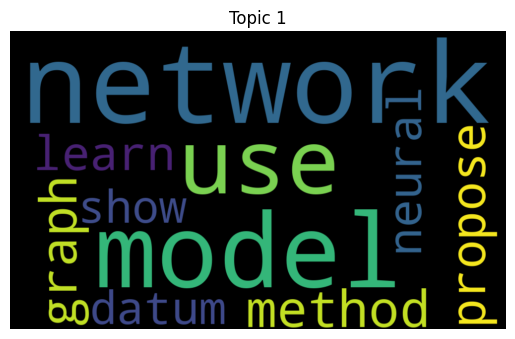

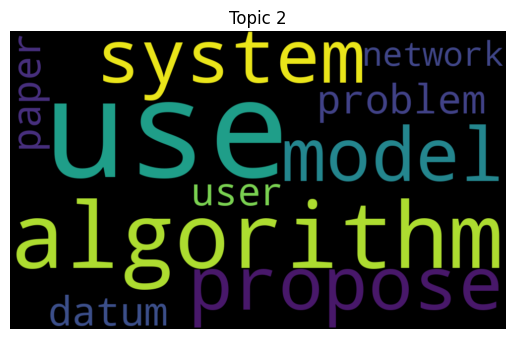

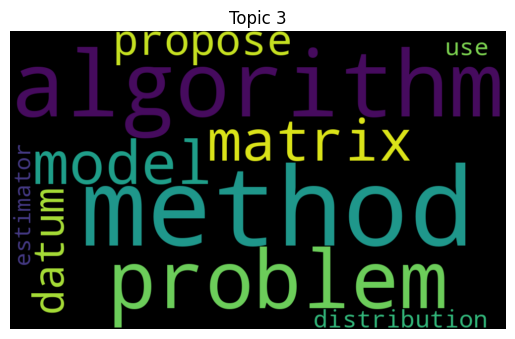

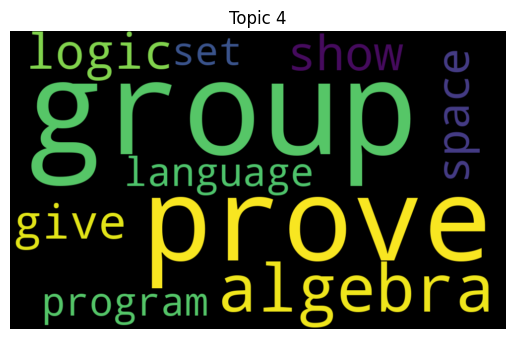

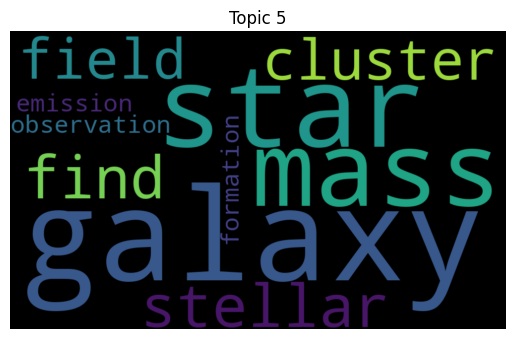

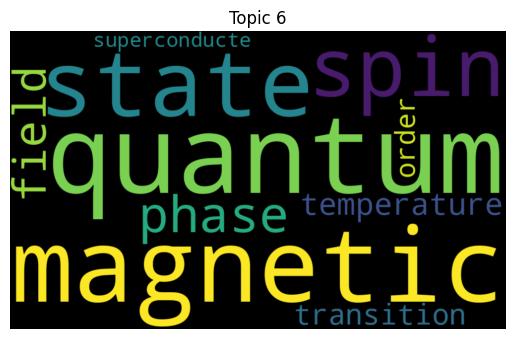

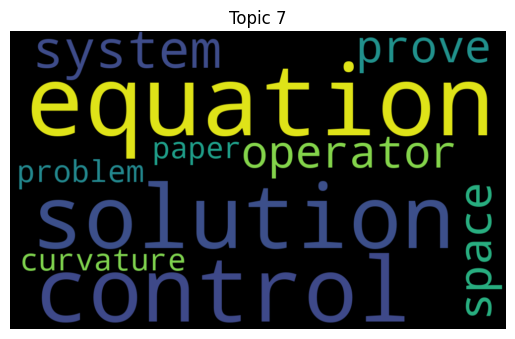

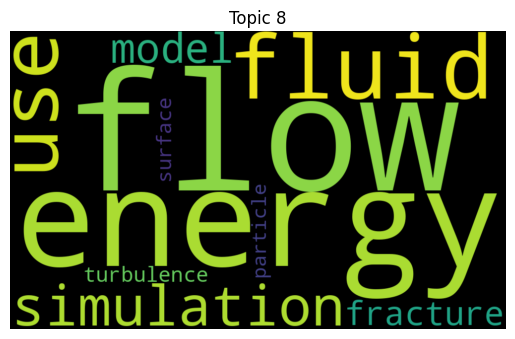

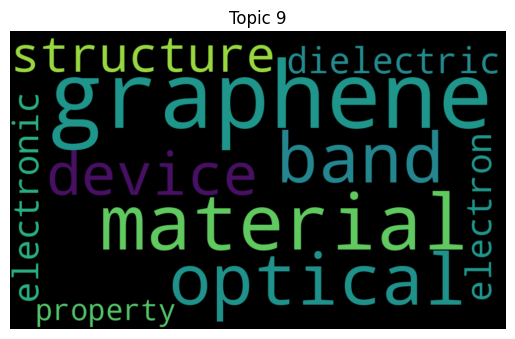

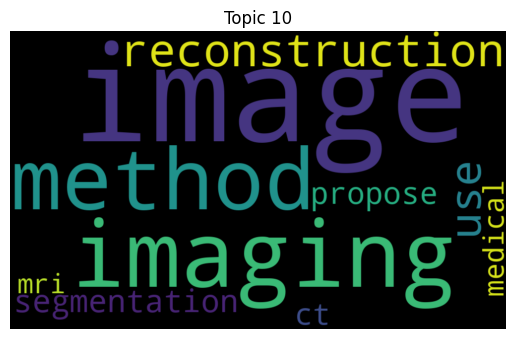

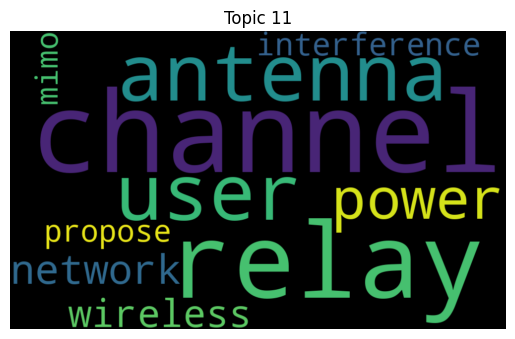

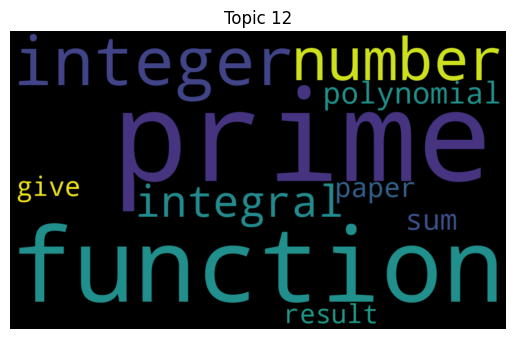

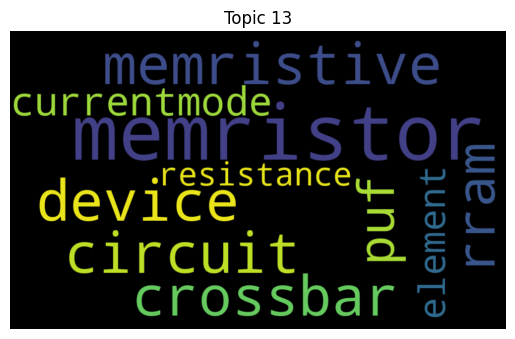

In [ ]:
for topic in range(13):
    create_wordcloud(model_2, topic)

In [ ]:
vectorizer = model_2.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in train['clean_abstract_lemmatized']]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in model_2.get_topic(topic)]
               for topic in range(len(set(headline_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.5768562024540542


In [ ]:
vectorizer = model_2.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in train['clean_abstract_lemmatized']]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in model_2.get_topic(topic)]
               for topic in range(len(set(headline_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='u_mass')
coherence = coherence_model.get_coherence()
print(coherence)

-2.5856171501392873
